# Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [656]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.style.use('seaborn')

import seaborn as sns
from datetime import datetime, timedelta

import missingno as msno

In [284]:
login = pd.read_json('logins.json')

In [267]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [268]:
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [269]:
login.dtypes

login_time    datetime64[ns]
dtype: object

In [270]:
login.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648247
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [271]:
login.isna().sum()

login_time    0
dtype: int64

In [272]:
print(f'The range of logins is from {min(login.login_time)} to {max(login.login_time)}')

print(f'The number of days is: {(max(login.login_time) - min(login.login_time))}')

The range of logins is from 1970-01-01 20:12:16 to 1970-04-13 18:57:38
The number of days is: 101 days 22:45:22


### Insight:
1. All logins are in 1970 from Januray 1st to April 13th.
2. The time range for the reported logins is approximately 101 days and 23 hours.

In [273]:
login.value_counts()

login_time         
1970-04-12 04:03:15    3
1970-02-12 11:16:53    3
1970-03-14 17:45:52    3
1970-01-06 21:45:52    3
1970-04-04 01:17:40    3
                      ..
1970-03-15 23:03:17    1
1970-03-15 23:04:57    1
1970-03-15 23:06:17    1
1970-03-15 23:06:24    1
1970-01-01 20:12:16    1
Length: 92265, dtype: int64

### Maximum of 3 logins per second is reported.

In [285]:
login['login_count'] = 1

In [286]:
login.set_index('login_time', inplace=True)

# Aggregate login counts based on 15­ minutes time intervals

In [295]:
login_15m = login.groupby(pd.Grouper(freq='15min')).sum()

In [368]:
print('The maximum logins per 15 minutes is:', login_15m.login_count.max())

The maximum logins per 15 minutes is: 73


In [369]:
print('The minimum logins per 15 minutes is:', login_15m.login_count.min())

The minimum logins per 15 minutes is: 0


### Generate meta data for the logins

In [370]:
login_15m['year'] = [d.year for d in login_15m.index]
login_15m['month'] = [d.strftime('%b') for d in login_15m.index]
login_15m['week_day'] = [d.strftime('%a') for d in login_15m.index]
login_15m['month_day'] = [d.day for d in login_15m.index]

login_15m['days_in_month'] = login_15m.index.days_in_month

In [473]:
login_15m.sample(5)

,login_count,year,month,week_day,month_day,days_in_month,hour
login_time,,,,,,,
1970-04-12 08:15:00,1,1970,Apr,Sun,12,30,8
1970-02-18 01:15:00,14,1970,Feb,Wed,18,28,1
1970-02-05 07:45:00,0,1970,Feb,Thu,5,28,7
1970-03-31 05:30:00,2,1970,Mar,Tue,31,31,5
1970-01-23 01:45:00,18,1970,Jan,Fri,23,31,1


### Aggregated login counts per months and week days

In [372]:
day_login = login_15m.groupby(['month', 'week_day'])[['login_count']].sum().unstack()
day_login.columns = day_login.columns.droplevel(0)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri','Sat', 'Sun']
months = ['Jan', 'Feb', 'Mar', 'Apr']
day_login = day_login.loc[:, days].reindex(months)
day_login

week_day,Mon,Tue,Wed,Thu,Fri,Sat,Sun
month,,,,,,,
Jan,1926,2124,2375,2640,3907,4642,3625
Feb,2355,2386,2670,3317,4092,5149,4704
Mar,3532,4168,3657,4058,4696,6345,7267
Apr,1010,590,1637,1945,2513,3241,2571


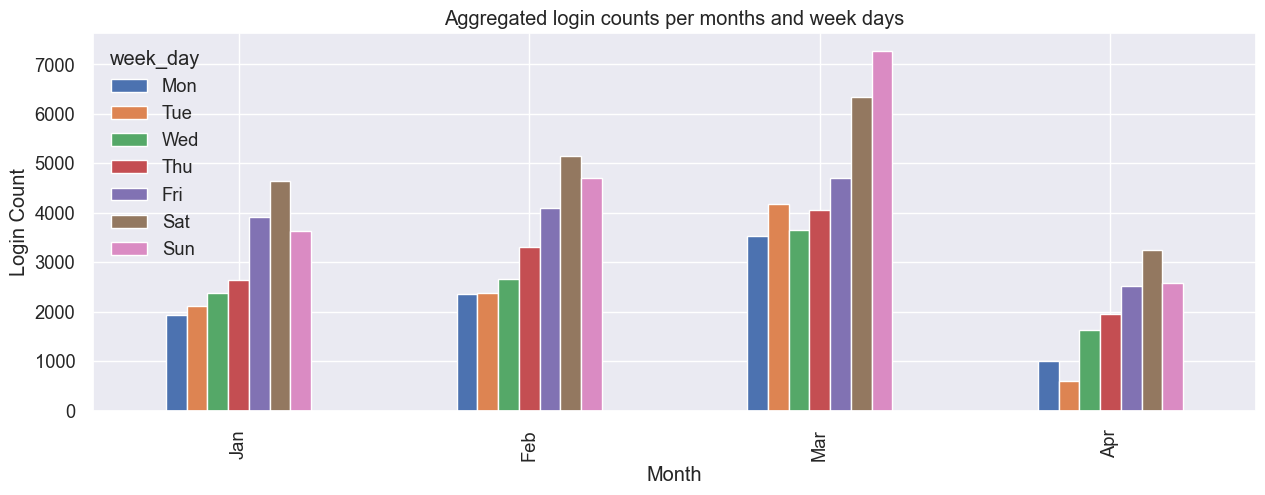

In [378]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
day_login.plot(kind='bar', ax=ax, xlabel='Month', ylabel='Login Count', title='Aggregated login counts per months and week days');

### Insights:
1. There is an increasing trend in logins from Jan to March. April month involved only 13 days. Thus, the drop in logins count in April does not indicate change in the increasing trend. The trend will be verified by line plots latter.
2. More logins encountered by the end of the weeks, Weekends in particular (Friday, Saturday, and Sunday)

### Average day logins count per month 

In [356]:
def login_per_month(x):
    result = {
        'ndays': x['month_day'].nunique(), # number of unique days reported in the dataset
        'login_count': x['login_count'].sum(),
    }
    return pd.Series(result)

month_login = login_15m.groupby(pd.Grouper(freq='M')).apply(login_per_month)

In [357]:
month_login['avg_login_per_day'] = (month_login.login_count / month_login.ndays).round(2)
month_login

,ndays,login_count,avg_login_per_day
login_time,,,
1970-01-31,31,21239,685.13
1970-02-28,28,24673,881.18
1970-03-31,31,33723,1087.84
1970-04-30,13,13507,1039.00


In [360]:
month_login.index = month_login.index.month

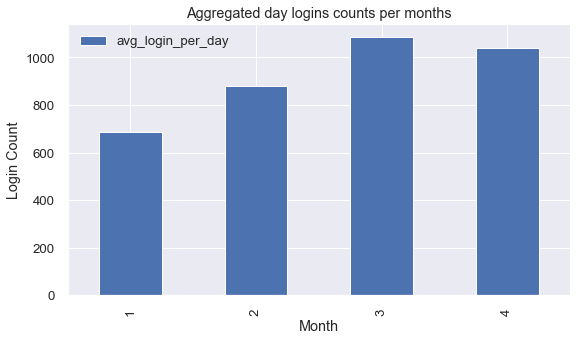

In [389]:
fig, ax = plt.subplots(figsize=(9,5))
month_login.plot(kind='bar',  y='avg_login_per_day', xlabel='Month', ylabel='Login Count', title='Aggregated day logins counts per months', ax=ax)
plt.show()

The average day logins confirm the increasing trend by month, however, April still slightly less than march. In fact, when we compared the first 13 days login counts in March we found that April did better than March in the first 13 days of each month. 

In [385]:
mask = (login_15m.index.month == 3) & (login_15m.index.day < 14)

In [392]:
print('The number of logins in the first 13 days in March is:', login_15m[mask]['login_count'].sum())
print('The number of logins in the first 13 days in April is:', login_15m[login_15m.index.month == 4]['login_count'].sum())

The number of logins in the first 13 days in March is: 12738
The number of logins in the first 13 days in April is: 13507


## Trend and Seasonality Analysis

In [452]:
def plot_trend(df, period):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
    df = df.groupby(pd.Grouper(freq='D'))[['login_count']].sum()

    df.plot(xlabel='Login Time', ylabel='Login Count', title=f'Login for {period}', ax = ax)
    years = mdates.YearLocator()
    weekdays = mdates.WeekdayLocator()
    months = mdates.MonthLocator()
    monthsFmt = mdates.DateFormatter('\n%b') 
    yearsFmt = mdates.DateFormatter('\n\n%Y')  # add some space for the year label
    weekdayFmt = mdates.DateFormatter('%a')

    ax.xaxis.set_minor_locator(weekdays)
    ax.xaxis.set_minor_formatter(weekdayFmt)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.tick_params(axis='x', which='minor', labelsize=12)
    plt.show()

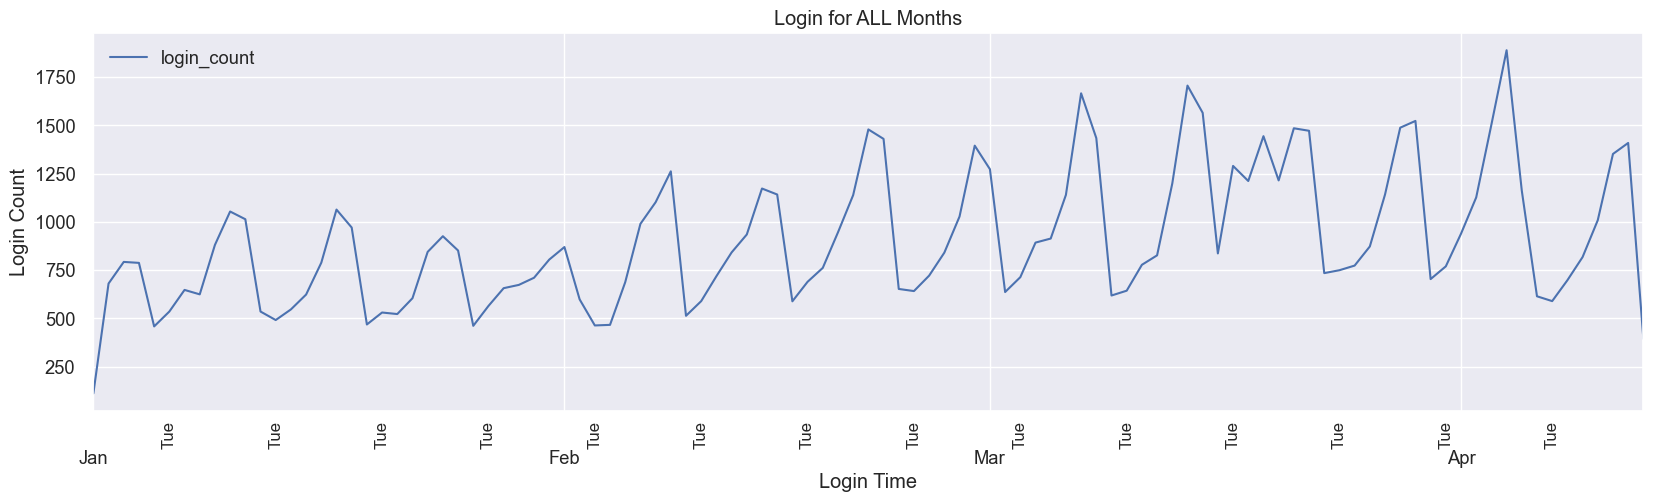

In [453]:
plot_trend(login_15m, 'ALL Months')

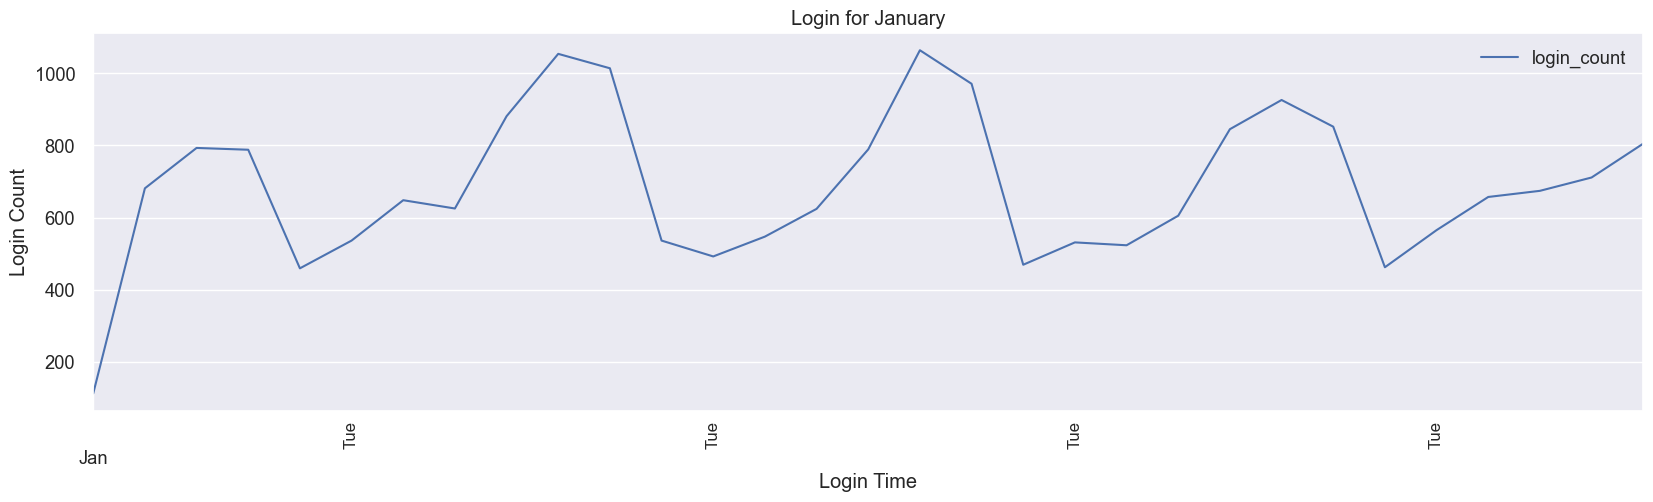

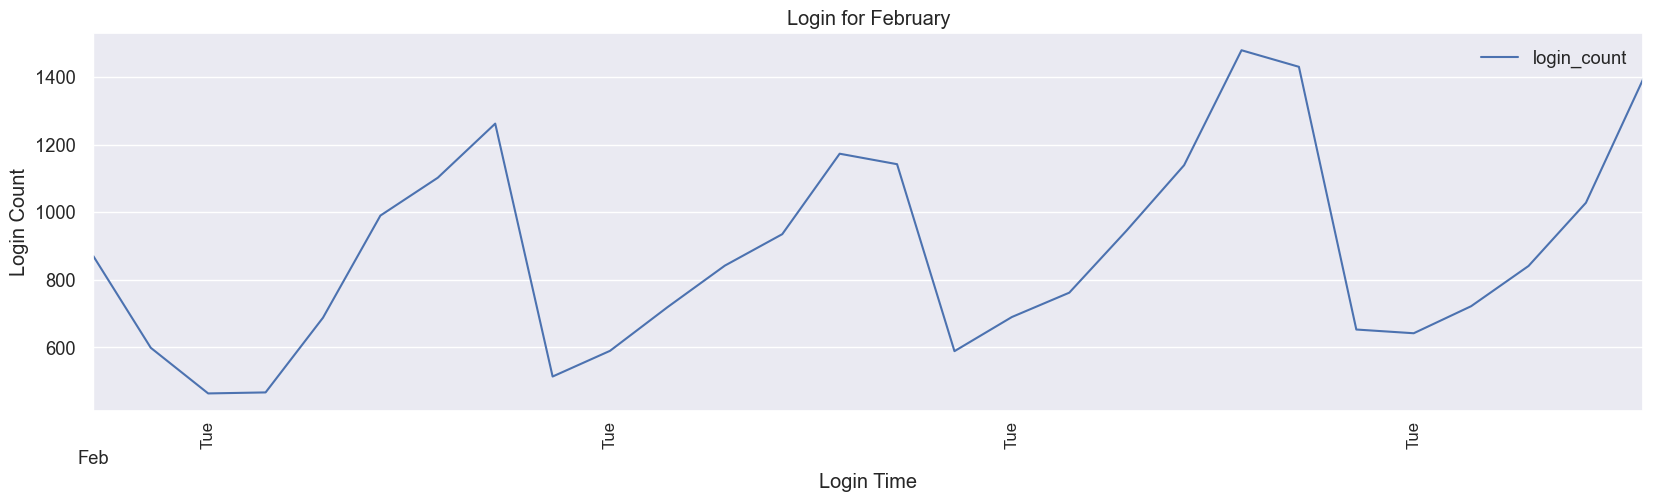

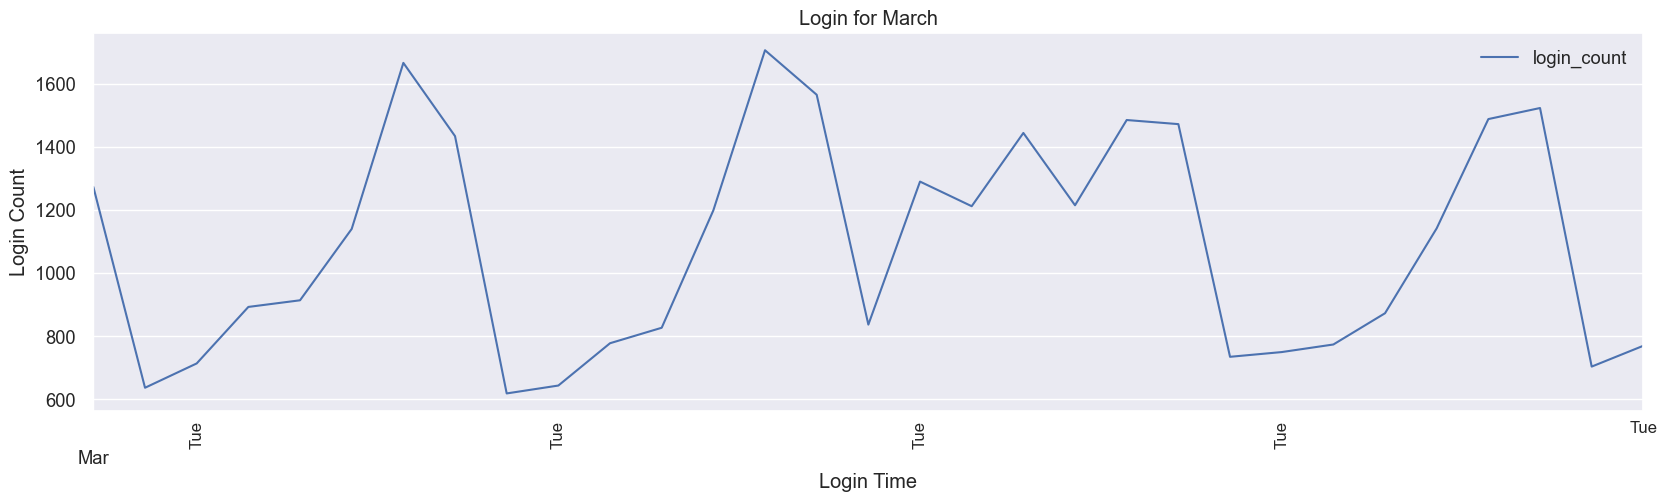

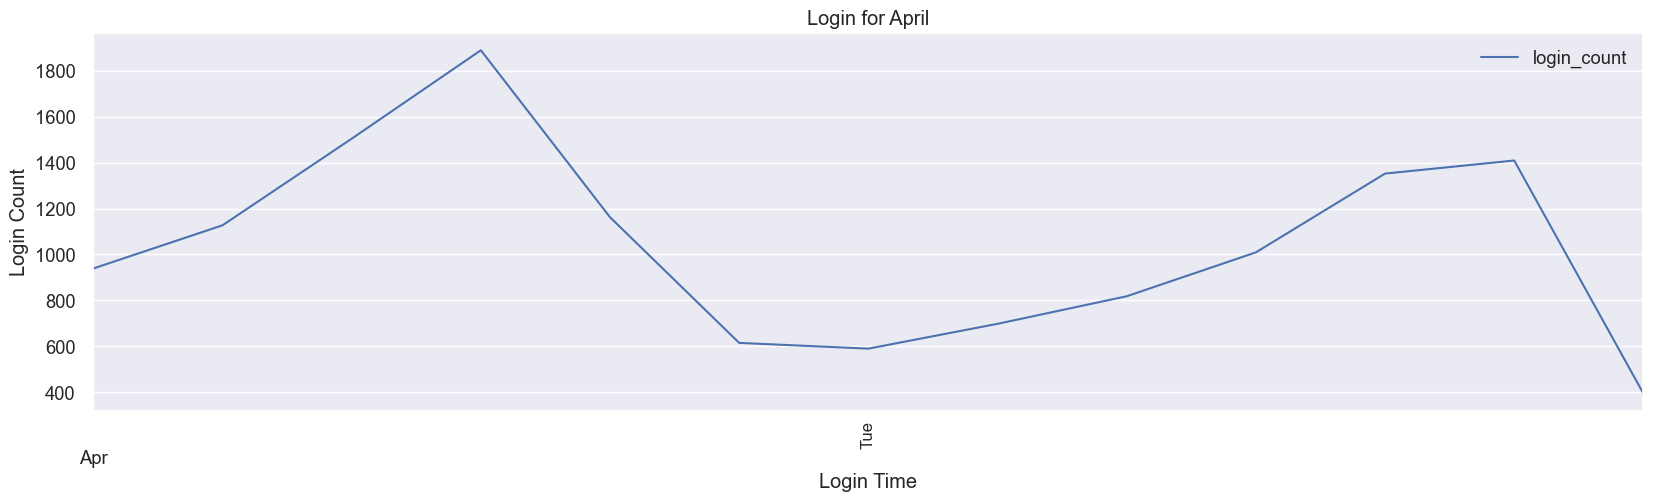

In [454]:
for month, text in zip(login_15m.index.month.unique(), login_15m.index.strftime('%B').unique()):
    
    df = login_15m[login_15m.index.month == month]
    plot_trend(df, text)
    

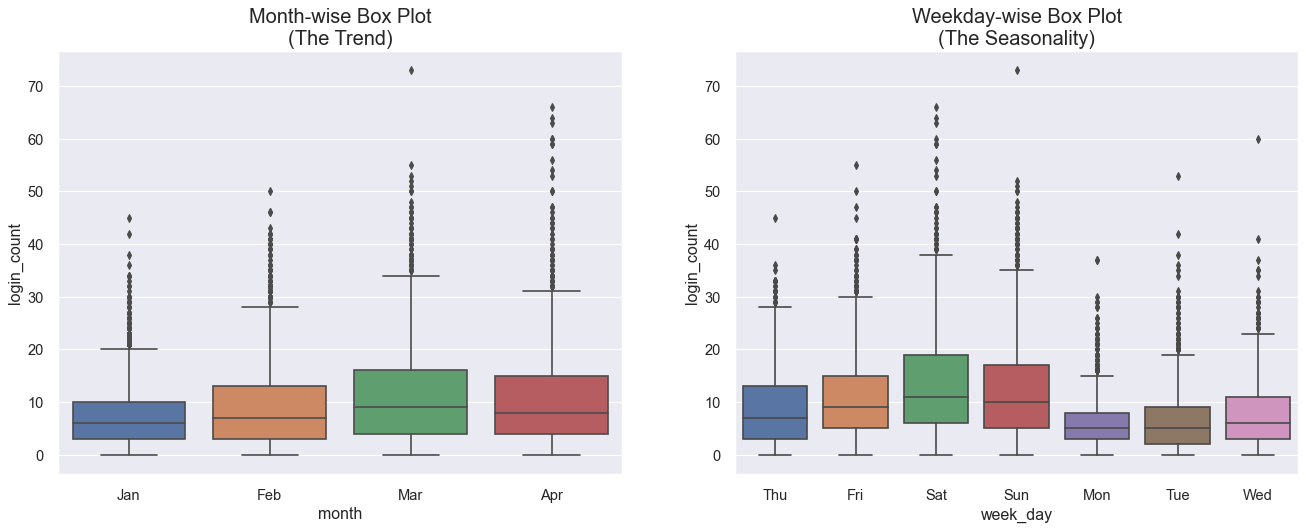

In [459]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='month', y='login_count', data=login_15m, ax=axes[0])
sns.boxplot(x='week_day', y='login_count', data=login_15m, ax=axes[1])

# Set Title
axes[0].set_title('Month-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Weekday-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### Insights:
1. The plots confirms an increasing trend of the logins.
2. The plots also show a weekly pattern (seasonality) of logins. Logins cunt is low at the beginning of the week and surge during the weekends (Friday, Saturday and Sunday).

In [472]:
login_15m['hour'] = login_15m.index.hour
login_15m.head()

,login_count,year,month,week_day,month_day,days_in_month,hour
login_time,,,,,,,
1970-01-01 20:00:00,2,1970,Jan,Thu,1,31,20
1970-01-01 20:15:00,6,1970,Jan,Thu,1,31,20
1970-01-01 20:30:00,9,1970,Jan,Thu,1,31,20
1970-01-01 20:45:00,7,1970,Jan,Thu,1,31,20
1970-01-01 21:00:00,1,1970,Jan,Thu,1,31,21


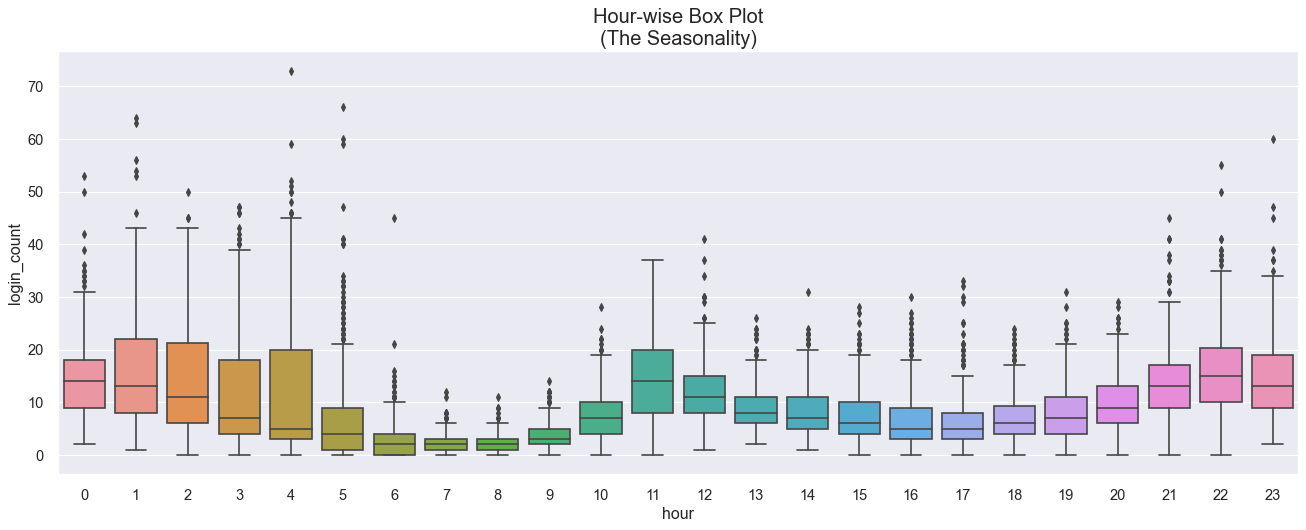

In [471]:
fig, ax = plt.subplots(figsize=(20,7), dpi= 80)
sns.boxplot(x='hour', y='login_count', data=login_15m, ax=ax)

ax.set_title('Hour-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

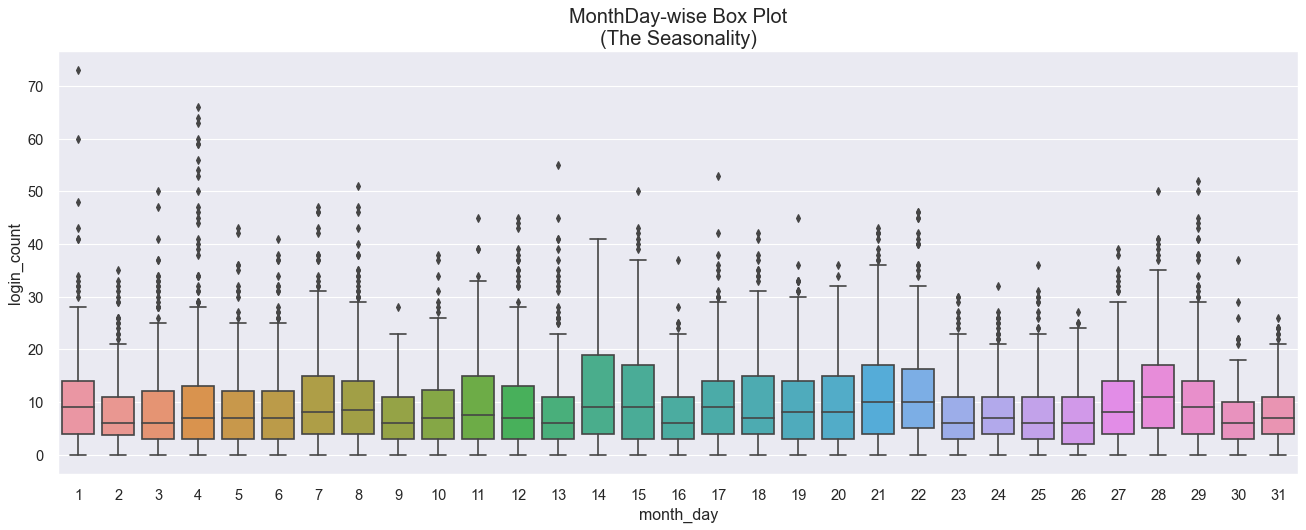

In [490]:
fig, ax = plt.subplots(figsize=(20,7), dpi= 80)
sns.boxplot(x='month_day', y='login_count', data=login_15m, ax=ax)

ax.set_title('MonthDay-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### Insights:
1. The logins peak at night (from 9 PM to 2 AM), at the midnight in particular, and peak at midday (11 AM and 12 PM).
2. The logins drop at the morning and evening.
3. The logins distribution is fairly similar for the days of the month.

## Moving Average Smoothing

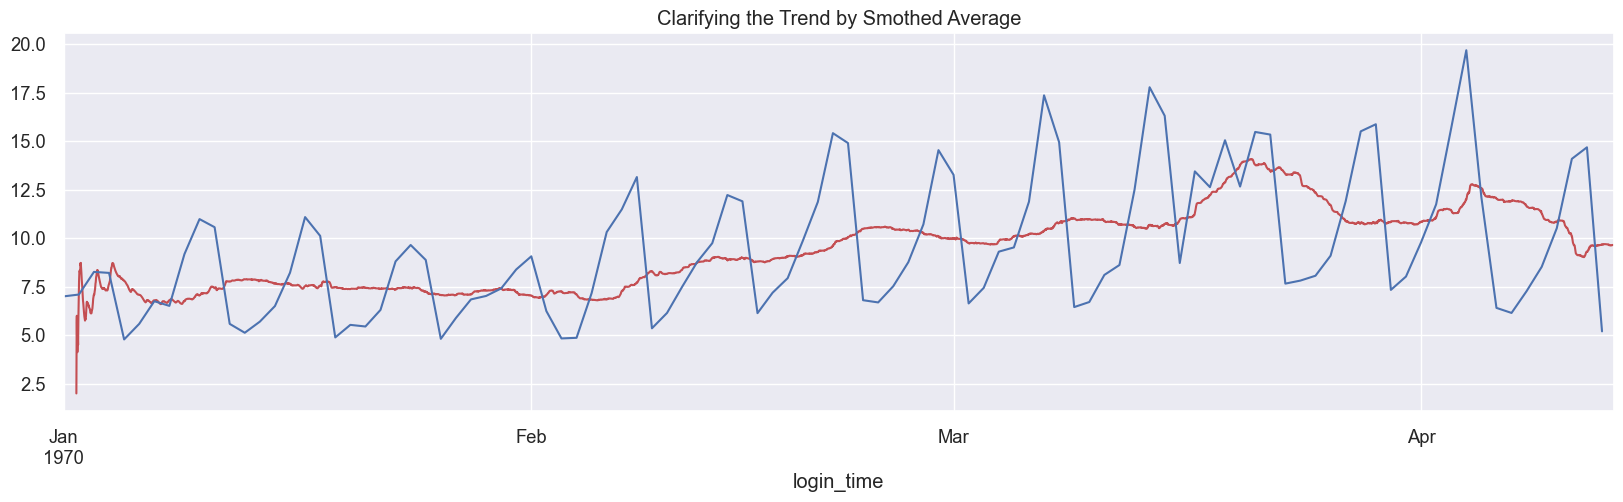

In [496]:
fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
login_15m.rolling('7d', min_periods=1)['login_count'].mean().plot(ax=ax, color='r', title='Clarifying the Trend by Smothed Average')
login_15m.groupby(pd.Grouper(freq='D'))[['login_count']].mean().plot(ax=ax, label='login average', legend=False)
plt.show()

## Summary
1. All logins are in 1970 from January 1st to April 13th.
2. The time range for the reported logins is approximately 101 days and 23 hours.
3. Maximum of 3 logins per second is reported.
4. The maximum logins per 15 minutes is: 73 and minimum is 0.
5. There is an increasing trend in logins from Jan to March. April month involved only 13 days. Thus, the drop in logins count in April does not indicate change in the direction of the trend per month.
6. The plots also show a weekly pattern (seasonality) of logins. Logins count is low at the beginning of the week and surge during the weekends (Friday, Saturday and Sunday).
7. The average day logins confirm the increasing trend by month, however, April still slightly less than march. In fact, when we compared the first 13 days login counts in March we found that April did better than March in the first 13 days of each month. 
8. The logins peak at night (from 9 PM to 2 AM), at the midnight in particular, and peak at midday (11 AM and 12 PM).
9. The logins drop at the morning and evening.
10. The logins distribution is fairly similar for the days of the month.

# Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    1. how you will implement the experiment
    2. what statistical test(s) you will conduct to verify the significance of the
observation
    3. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Q1 Ans:
* The objective of Ultimate managers of city operations by reimbursing all toll costs is to make driver partners available in both cities rather than sticking in one city. Thus, the average number of drivers that cross the toll ridge per day is a a reasonable success metric.
* The increase of the daily average number of driver partners who crosses the toll ridge indicates the effectiveness of the toll  reimbursement experiment. 


## Q2 Ans:

### Experiment Implementation
The experiment is to compare the daily average (arithmetic mean) of driver partners who cross the toll bridge before and after the  reimbursement of toll costs. The steps are as follows:
1. We make two groups, control and treatment groups. 
    - The **control group** involves driver partners who cross the toll bridge before the reimbursement. 
    - The **treatment group** involves driver partners who cross the toll bridge during the reimbursement.
    - We count the daily number of driver partners who pass the bridge in each group. We assign 3 months for each group to take this measurement. The aim is to have enough representative sample data to estimate the population mean for each group. We need sufficient sample size, we can adjust the experiment duration accordingly.
2. we measure the sample mean for each group. $ \mu_0$ for control group, and $\mu_1$ for treatment group.
**Notice**: Good estimate of the population mean for the control group (daily average driver partners before reimbursement) is likely to be known from previous / historic data. In this case, we can conduct the experiment for 3 month only on the treatment group and measure the sample mean.
3. We use upper-tailed t-test, and hypothesis are as follows:
- null hypothesis H0: true mean difference between groups mean is equal to zero ($ \mu_1 - \mu_0 = 0$)
- alternative upper-tailed hypothesis H1:  the difference groups mean is greater than zero ($ \mu_1 - \mu_0 > 0$)


### The choice of the statistical test:
Based on the experiment implementation, there are two options:
1. if we used the known population mean of the controlled group, we use **one-sample t-test** with significant lever $\alpha = 0.05$, this is most likely to be the case.
2. if we ran the experiment on the control group we use **two-sample t-test** (also known as the independent samples t-test), $\alpha = 0.05$.

### Interpreting the results
- We obtain the t statistic and P value by running the test and compare to the significant level $\alpha = 0.05$.  P value is the probability of observing as extreme mean difference or more extreme if the null hypothesis were true. If p value > 0.05 we reject the null hypothesis in favor of the alternative hypothesis. Meaning there is a significant increase of the driver partners crossing the toll bridge during the reimbursement. On the other hand, p value < 0.05 indicates that the observed mean simply due to chance.
- if there is a significant difference in mean, the city operations team can look to the margin of increase to determine if it is worth to place a reimbursement of the toll costs.

### Caveats
two sample test relies on a strong assumptions, we need to make sure that these assumptions hold to have a reliable test results:
- Data in each group must be obtained via a random sample from the population.
- Data in each group are approximately normally distributed.
- Data values are continuous.
- The variances for the two independent groups are equal.
In case these assumptions do not hold, we can use ***Bootstrap hypothesis testing** instead. The advantage of the bootstrap is that it can estimate the sampling distribution without many of the assumptions needed by parametric methods.


# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

In [499]:
df = pd.read_json('ultimate_data_challenge.json')

In [500]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

## Data Cleaning and EDA

### Fix Data Types

In [570]:
# change date columns to date format
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

In [571]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

### Check Missing Data

In [535]:
def missing_values(df):
    '''this function return the count and % of missing data for each column in the dataframe'''
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['missing values count', '%']
    return missing.sort_values(by='missing values count', ascending=False)

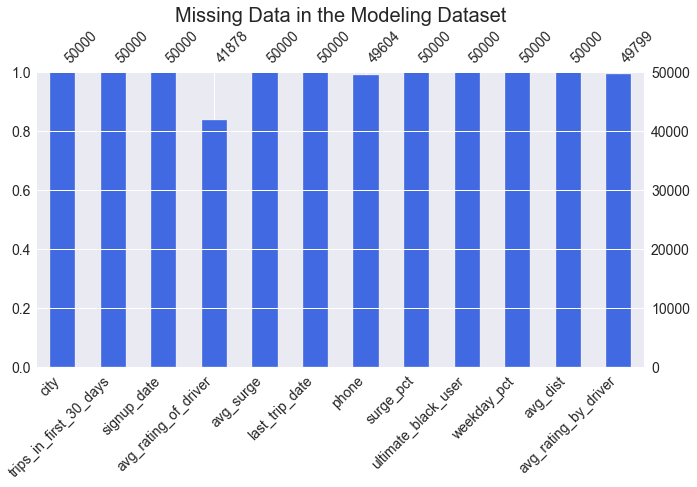

,missing values count,%
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000


In [529]:
f, ax = plt.subplots(figsize=(10,7))
msno.bar(df, color="royalblue", ax=ax, fontsize=14, labels=True, );
ax.set_title('Missing Data in the Modeling Dataset', fontsize= 20)

plt.tight_layout()
plt.show()
missing_values(df)

### Exploring signup column

In [555]:
signup_min = df.signup_date.min()
signup_max = df.signup_date.max()
print(f'The range of signup dates is from: {signup_min} to {signup_max}, which is {signup_max - signup_min}.')

The range of signup dates is from: 2014-01-01 00:00:00 to 2014-01-31 00:00:00, which is 30 days 00:00:00.


In [575]:
from matplotlib.dates import DateFormatter


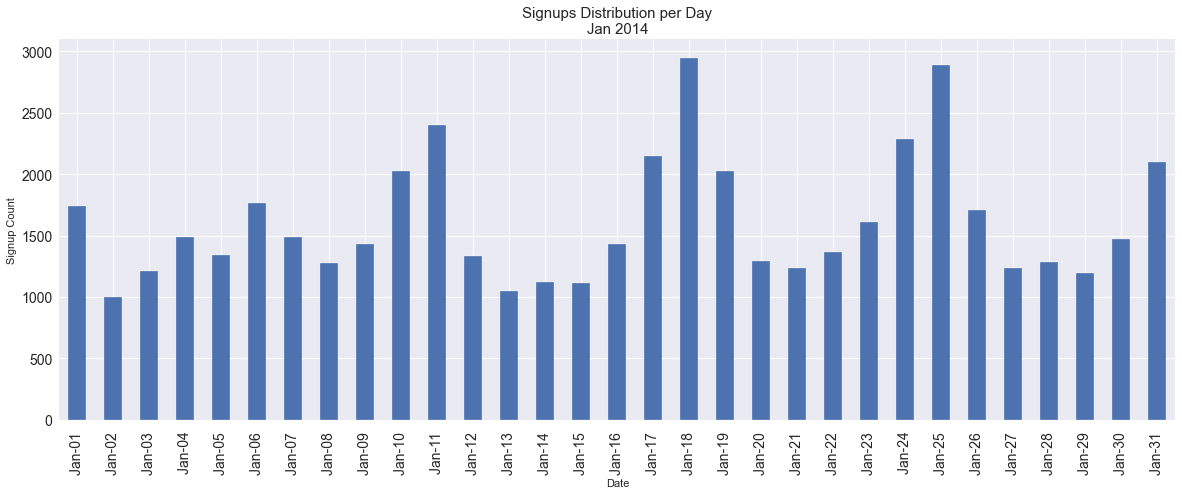

In [603]:
fig, ax = plt.subplots(figsize=(20, 7))
df.groupby(pd.Grouper(key='signup_date', freq='D'))['signup_date'].count().plot(kind='bar', ax=ax, fontsize = 14)

date_form = DateFormatter("%b-%d ")

ax.xaxis.set_major_formatter(date_form)
ax.set(xlabel = 'Date',
       ylabel="Signup Count",
       title="Signups Distribution per Day\nJan 2014",
      )
ax.title.set_size(15)
plt.show()

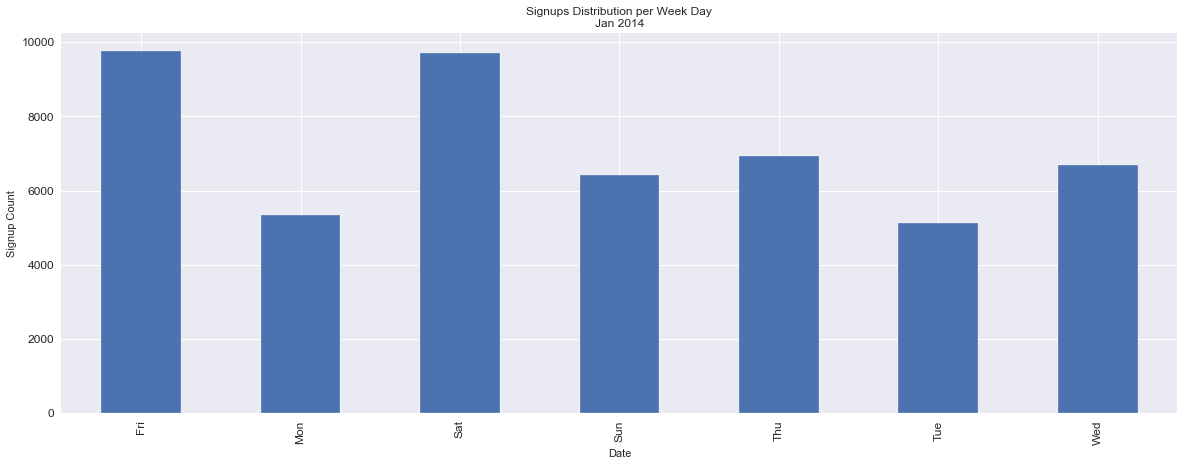

In [626]:
fig, ax = plt.subplots(figsize=(20, 7))
df.groupby(df.signup_date.dt.strftime('%a'))['signup_date'].count().plot(kind='bar', ax=ax, fontsize = 12)
# date_form = DateFormatter(" (%A)")

# ax.xaxis.set_major_formatter(date_form)
ax.set(xlabel = 'Date',
       ylabel="Signup Count",
       title="Signups Distribution per Week Day\nJan 2014",
      )
plt.show()

- Most sign-ups took place in Friday and Saturday.

### Exploring "last_trip_date" column

In [631]:

df.last_trip_date.min()

last_trip_date_min = df.last_trip_date.min()
last_trip_date_max = df.last_trip_date.max()
print(f'The range of last_trip_date is from: {last_trip_date_min} to {last_trip_date_max}, which is {last_trip_date_max - last_trip_date_min}.')

The range of last_trip_date is from: 2014-01-01 00:00:00 to 2014-07-01 00:00:00, which is 181 days 00:00:00.


## Generate Retained Users Column (the target column for modeling)
The users is considered retained if they were “active” (i.e. took a trip) in the preceding 30 days. Last date for reporting the trips is July 01, 2014. Thus, active users would have a trip in time frame before 30 days from this last date

In [633]:
active_users_cutoff_date = last_trip_date_max - timedelta(days=30)
print(f'Active users cut-off date is:', active_users_cutoff_date)

Active users cut-off date is: 2014-06-01 00:00:00


In [714]:
df['retained'] = df.last_trip_date >= active_users_cutoff_date
df['retained'] = df.retained.map({True: 'yes', False: 'no'})

In [715]:
df.retained.value_counts()

no     31196
yes    18804
Name: retained, dtype: int64

In [716]:
def feature_counts(feature, df=df):
    ''' Calculates the count and percentage of each value of a categorical variable'''
    counts = pd.concat([df[feature].value_counts(), round(100 * df[feature].value_counts()/df.shape[0], 2)], axis=1)
    counts.columns=['count', '%']
    counts.reset_index(inplace =True)
    counts.rename(columns={'index': feature}, inplace=True)
    return counts

In [717]:
def distribution_bar_plot(feature, df):

    fig, ax = plt.subplots(figsize=(8, 2))    
    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[feature].value_counts().index, ax=ax, palette='Blues')
    ax.set_title(f'The Percentage Count of "{feature}" Values' )
    ax.set_xlabel('Percentage Count')
    ax.set_ylabel(f'{feature}')
    #ax.axis("off")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
        
    plt.show()

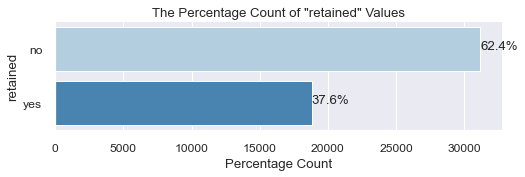

,retained,count,%
0,no,31196,62.39
1,yes,18804,37.61


In [718]:
distribution_bar_plot('retained', df)
feature_counts('retained')

**The fraction of retained users is 37.61%. There imbalance in this target variable.**

## Exploring Categorical Features

### Exploring the "city" column

In [719]:
feature_counts('city')

,city,count,%
0,Winterfell,23336,46.67
1,Astapor,16534,33.07
2,King's Landing,10130,20.26


In [720]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [721]:
print(f'There are {df.city.nunique()} cities: {df.city.unique()}')

There are 3 cities: ["King's Landing" 'Astapor' 'Winterfell']


### Cramér's V function
Cramér's V is a measure of correlation between categorical variables. We are using it to measure the correlation with the target variable.

In [722]:
# This code is taken from this source: (https://www.kaggle.com/phaethonprime/eda-and-logistic-regression)
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [737]:
# Bar plot for the distribution of the categorical fatures.
def distibution_bar_plot(feature, retained= 'retained'):
    # priniting the unique values for each feature
    print(f'\n--------   The distribution of {feature} -----------\n')
    uniq = df[feature].unique()
    print('{}: {} distinct values -  {}\n'.format(feature,len(uniq),uniq))
    print('\t Note:The shown pecentatges % are based on the total of all users in the data, retained and not retained.\n')
    sns.set(font_scale=1.1)

    # resizing the figure according to the number of categories for visualization coordination
    if len(uniq) > 7:
        fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    elif len(uniq) <= 2 : 
        fig, ax = plt.subplots(1, 2, figsize=(18, 3))
            
    else:
         fig, ax = plt.subplots(1, 2, figsize=(18, 4))
        

    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[feature].value_counts().index, ax=ax[0], palette='Blues')
    ax[0].set_title(f'The Percentage Count of "{feature}" Categories', )
    ax[0].set_xlabel('Percentage Count')
    ax[0].set_ylabel(f'{feature}')
    #ax[0].axis("off")
    ax[0].set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax[0].patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax[0].annotate(percentage, (x, y))
            
            
    # Ploting the distribution of each variable values along with the retained varaible in the second subplot
    sns.countplot(y=feature, data=df, hue='retained', order = df[feature].value_counts().index, ax=ax[1], palette='Blues')
    total = len(df[feature])
    for p in ax[1].patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax[1].annotate(percentage, (x, y))
    ax[1].set_title(f'The Percentage Count of "{feature}" Categories with the retained Vriable')
    ax[1].set_xlabel('Percentage Count')
    #ax[1].axis("off")

    plt.subplots_adjust(wspace=0.2);
    plt.show()
    
    # prinitng the Cramér's V value by passing the confusion matrix between the feature and the retained variable
    print("Cramér's V = " , cramers_corrected_stat(pd.crosstab(df[feature], df["retained"])))


--------   The distribution of city -----------

city: 3 distinct values -  ["King's Landing" 'Astapor' 'Winterfell']

	 Note:The shown pecentatges % are based on the total of all users in the data, retained and not retained.



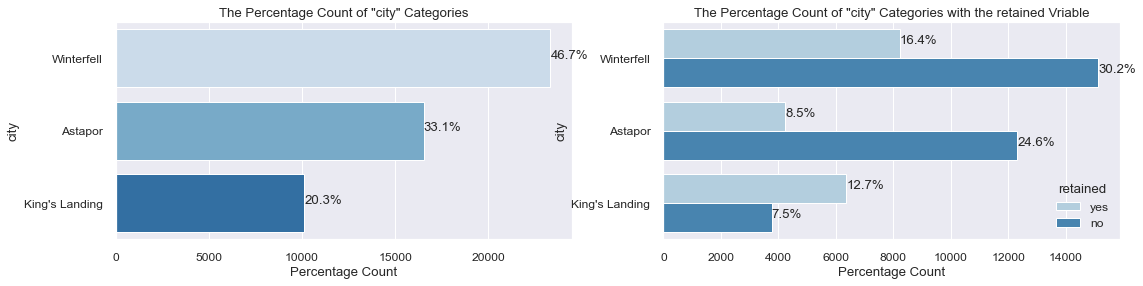

Cramér's V =  0.2763920178525631


In [724]:
distibution_bar_plot('city', 'retained')

### Insights:
- The city of Winterfehas the most trips.
- Cramér's V = 0.27 indicates week correlation between the city and the target variable "retained."

### Exploring the "phone" column

In [712]:
feature_counts('phone')

,phone,count,%
0,iPhone,34582,69.16
1,Android,15022,30.04



--------   The distribution of phone -----------

phone: 3 distinct values -  ['iPhone' 'Android' None]

	 Note:The shown pecentatges % are based on the total of all users in the data, retained and not retained.



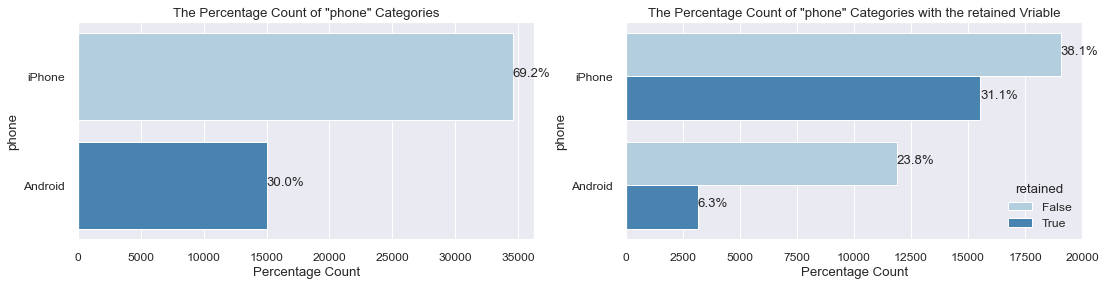

Cramér's V =  0.22706221265404983


In [677]:
distibution_bar_plot('phone', 'retained')

In [678]:
df.phone.isna().sum()

396

### Insights:
- There are 396 missing values of the phone feature shown as None above.
- Most of the users are using iPhone.

- Cramér's V = 0.22 indicates week correlation between the phone and the target variable "retained."

## Exploring Numerical Features

### The **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up

In [725]:
def distribution_plot(var):

    # Initialize the matplotlib figure
    fig, ax = plt.subplots(1, 2, figsize=(20.0, 10))
    fig.suptitle(var.capitalize() + ' Distribution', fontsize=15 )
    palette = sns.color_palette("Paired", 2)
    
    # Plot the distribution as a Histogram
    sns.histplot(data= df, x = var, hue='retained', bins=50, ax=ax[0], kde= True )

    #dist_plot = sns.displot(df[var], bins=50, rug=True, ax=ax[0])
    ax[0].set_xlabel(var,fontsize=15)
    mean = df[var].mean(); median = df[var].median() 

    ax[0].axvline(mean, color='r', linestyle='--', label='{:5.0f}'.format(mean))
    ax[0].axvline(median, color='g', linestyle='-')
    # Box plot 
    sns.boxplot(data = df, x= var, y= df['retained'], ax=ax[1])
    ax[1].set_xlabel(var,fontsize=15)
    ax[1].set_ylabel("retained", fontsize=15)
    

    plt.tight_layout(h_pad=2)
    plt.show()
    # Print the second and third quartile

    classes_description = df.groupby('retained')[[var]].describe()
    print(f'The {var} description for for both respnse classes =\n {classes_description}')

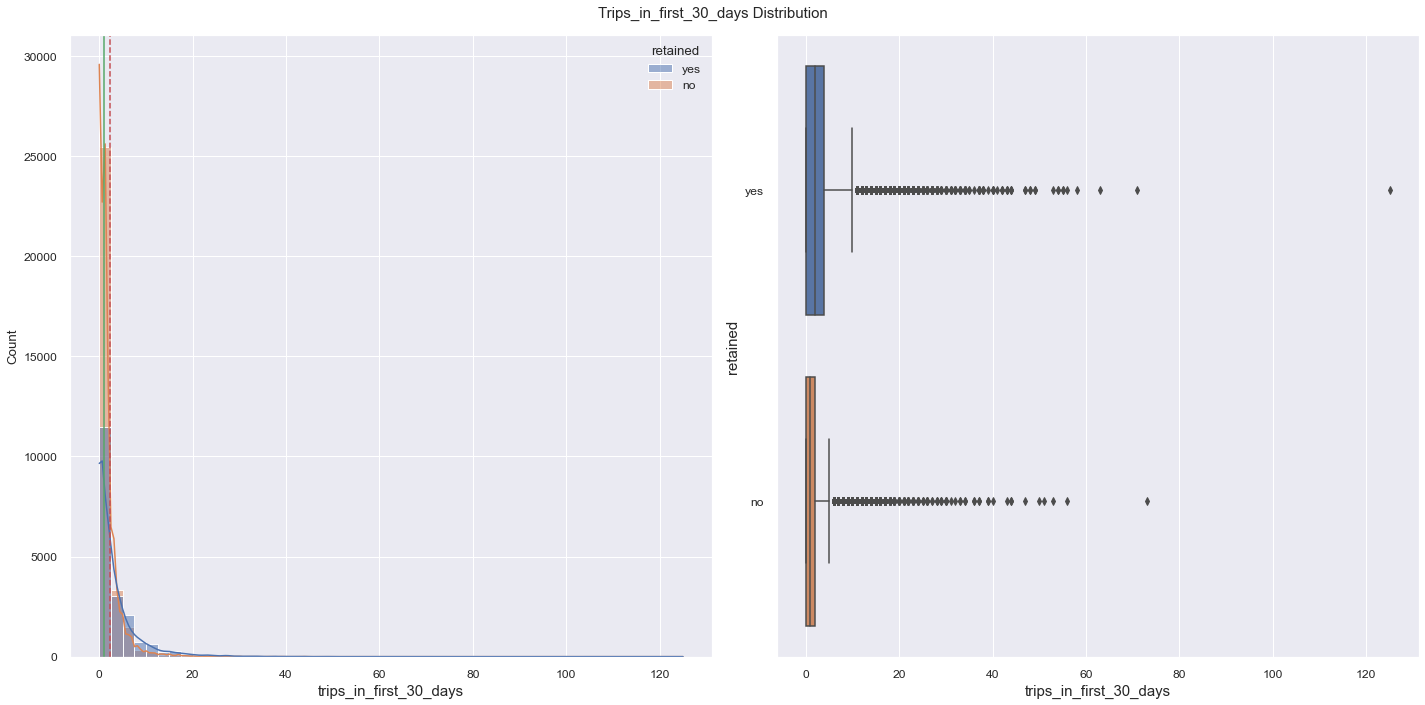

The trips_in_first_30_days description for for both respnse classes =
          trips_in_first_30_days                                               
                          count      mean       std  min  25%  50%  75%    max
retained                                                                      
no                      31196.0  1.658482  2.654222  0.0  0.0  1.0  2.0   73.0
yes                     18804.0  3.306318  4.986743  0.0  0.0  2.0  4.0  125.0


In [726]:
distribution_plot('trips_in_first_30_days')

### Insights:
- For retained users, the median is 2 trips in the first 30 days after signing up and median = 1 for none retained.
- There are outliers in both classes.
- The retained users seems to have slightly more trips in the first 30 days after signing up.

- ### The **avg_dist:** the average distance in miles per trip taken in the first 30 days after signup

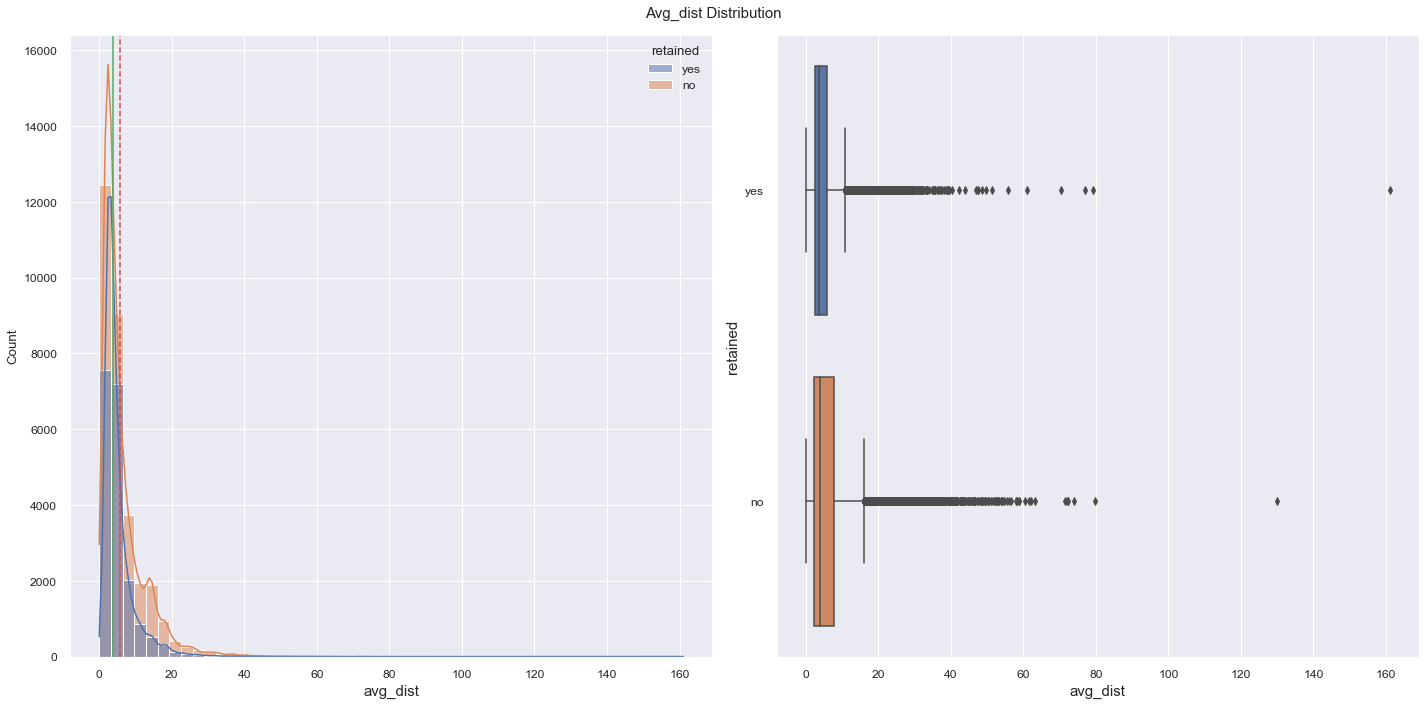

The avg_dist description for for both respnse classes =
          avg_dist                                                   
            count      mean       std  min   25%   50%   75%     max
retained                                                            
no        31196.0  6.207939  6.238675  0.0  2.32  4.03  7.80  129.89
yes       18804.0  5.114788  4.615175  0.0  2.56  3.73  5.89  160.96


In [728]:
distribution_plot('avg_dist')

### Insights:
- For retained users, the median of average distance per trip is 3.73 and median = 4.03 for none retained users.
- There are outliers in both classes.
- The retained users seems to have slightly less average distance per trip.

### The **avg_rating_by_driver**: the rider’s average rating over all of their trips

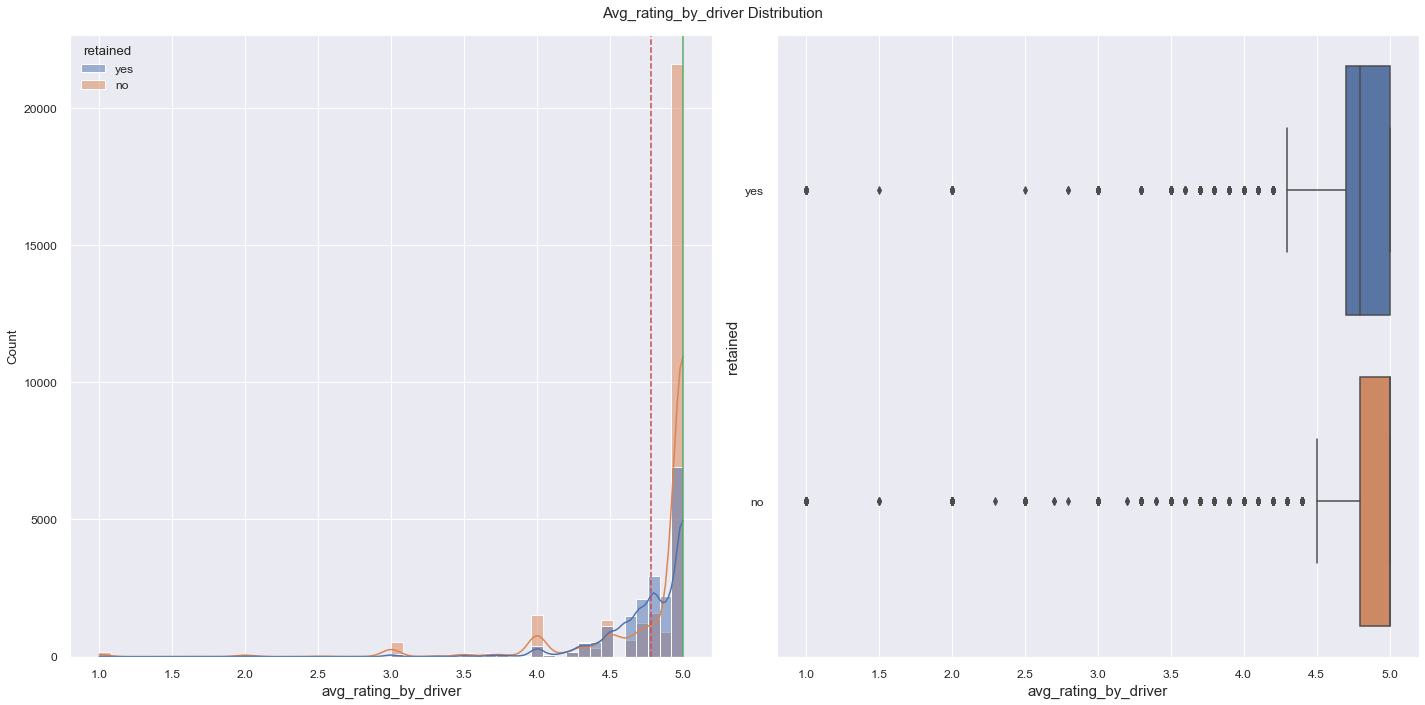

The avg_rating_by_driver description for for both respnse classes =
          avg_rating_by_driver                                             
                        count      mean       std  min  25%  50%  75%  max
retained                                                                  
no                    31031.0  4.787464  0.504648  1.0  4.8  5.0  5.0  5.0
yes                   18768.0  4.762772  0.328489  1.0  4.7  4.8  5.0  5.0


In [729]:
distribution_plot('avg_rating_by_driver')

### Insights:
- For retained users, the median of average rating by drivers is 5 and median = 4.8 for none retained users.
- There are outliers in both classes.
- The none retained users seems to have the rating at the higher. However, the distribution is more or less similar for both classes.

### The **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips

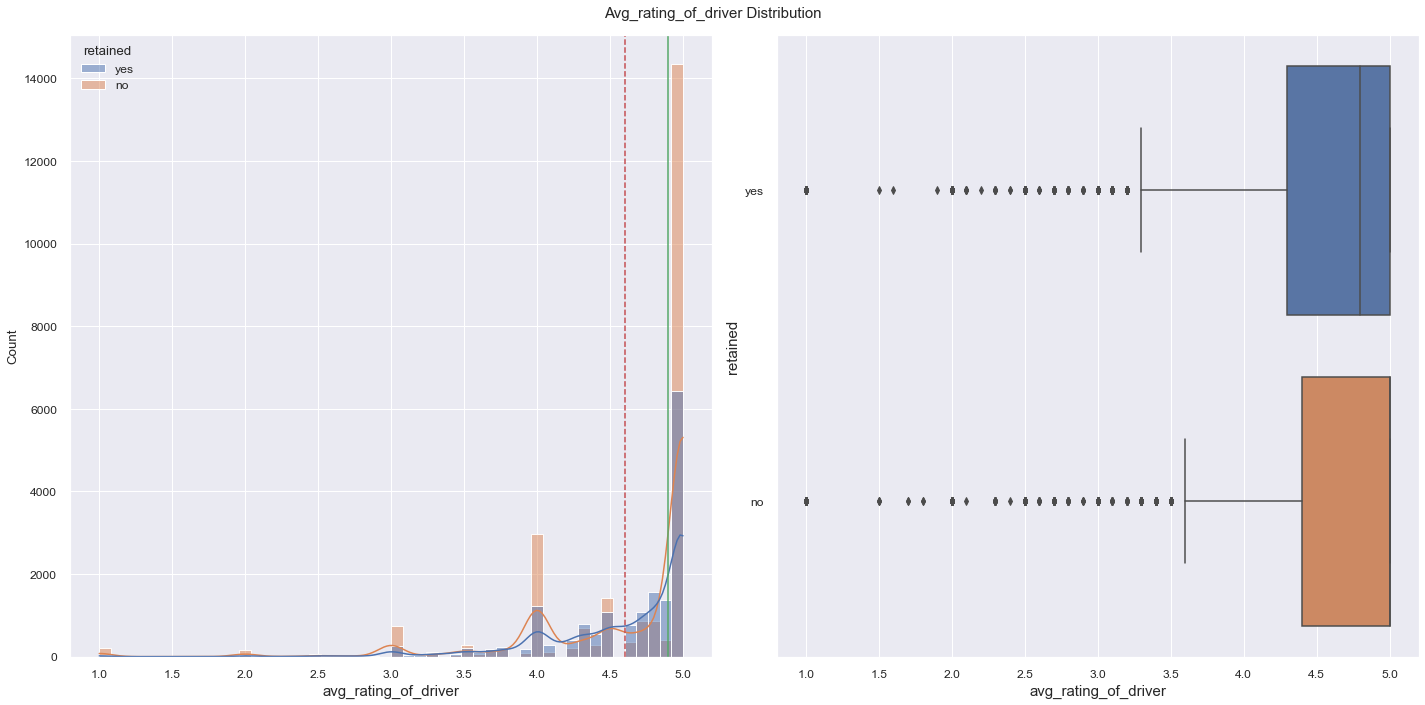

The avg_rating_of_driver description for for both respnse classes =
          avg_rating_of_driver                                             
                        count      mean       std  min  25%  50%  75%  max
retained                                                                  
no                    24706.0  4.607557  0.664418  1.0  4.4  5.0  5.0  5.0
yes                   17172.0  4.592930  0.542386  1.0  4.3  4.8  5.0  5.0


In [730]:
distribution_plot('avg_rating_of_driver')

### Insights:
- For retained users, the median of average rating of driver by user = 4.8 and median = 5.5 for none retained users. None retained users seem to rate drivers slightly higher. However, both classes have similar distribution.
- There are outliers in both classes.

### The **surge_pct**: the percent of trips taken with surge multiplier > 1

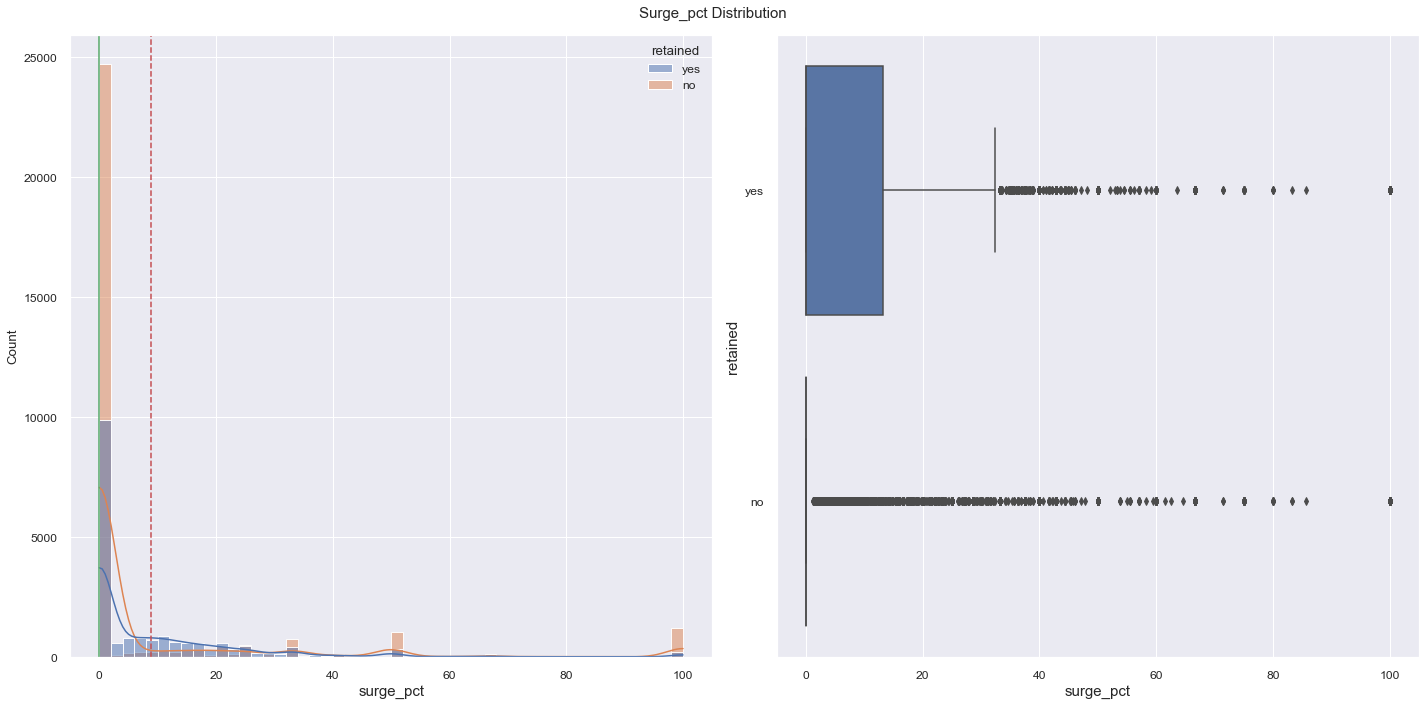

The surge_pct description for for both respnse classes =
          surge_pct                                                 
             count      mean        std  min  25%  50%   75%    max
retained                                                           
no         31196.0  8.666739  22.179139  0.0  0.0  0.0   0.0  100.0
yes        18804.0  9.152797  15.588704  0.0  0.0  0.0  13.3  100.0


In [731]:
distribution_plot('surge_pct')

In [733]:
df.surge_pct.value_counts()

0.0      34409
100.0     1416
50.0      1367
33.3      1152
25.0       906
         ...  
27.9         1
34.7         1
62.5         1
29.3         1
26.4         1
Name: surge_pct, Length: 367, dtype: int64

### Insights:
- most of the trips are without surge fir both classes. However, the plots shows that retained users have more trips with higher surge.
- There are outliers in both classes.

### The **avg_surge: The average surge multiplier over all of this user’s trips

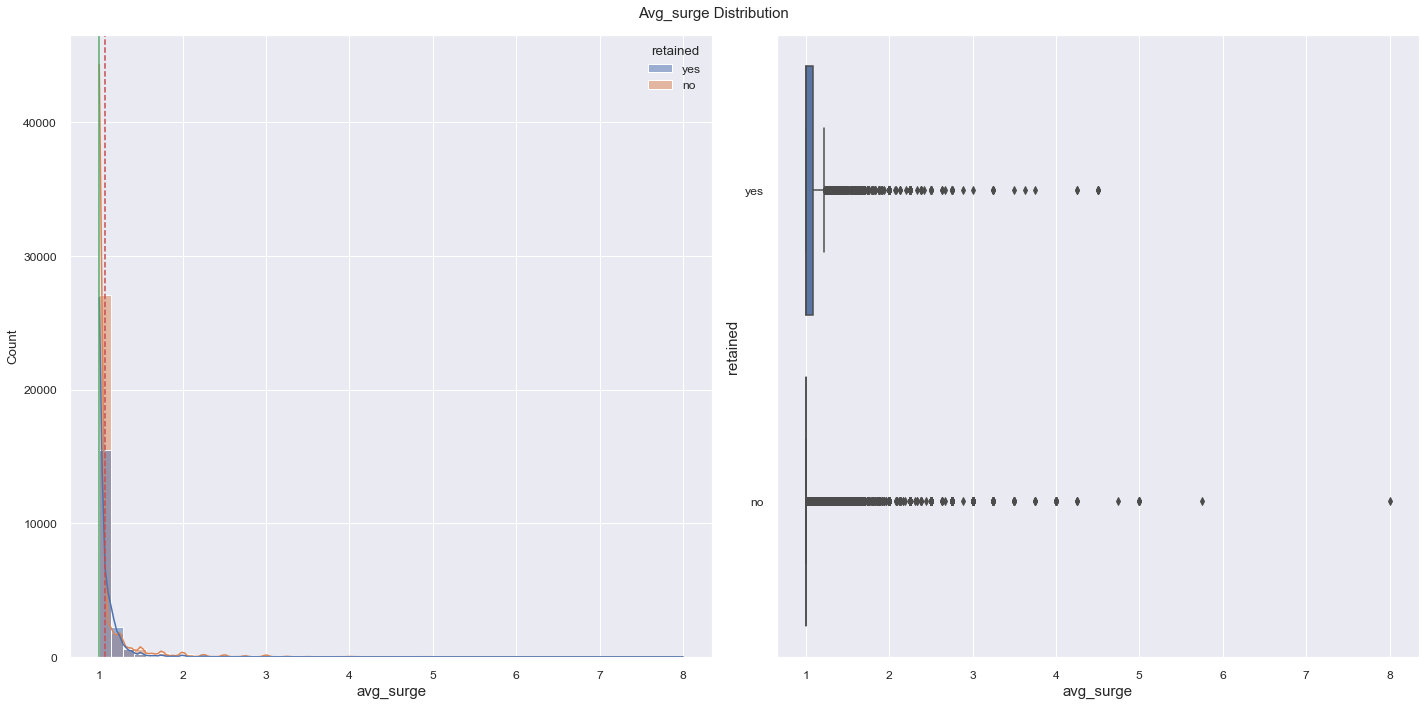

The avg_surge description for for both respnse classes =
          avg_surge                                              
             count      mean       std  min  25%  50%   75%  max
retained                                                        
no         31196.0  1.075339  0.251361  1.0  1.0  1.0  1.00  8.0
yes        18804.0  1.073809  0.163170  1.0  1.0  1.0  1.09  4.5


In [734]:
distribution_plot('avg_surge')

### Insights:
- Both classes have slightly similar distribution. However, retained users seems to be experienced a bit higher average surge multiplier.
- There are outliers in both classes.

### The **weekday_pct**: the percent of the user’s trips occurring during a weekday

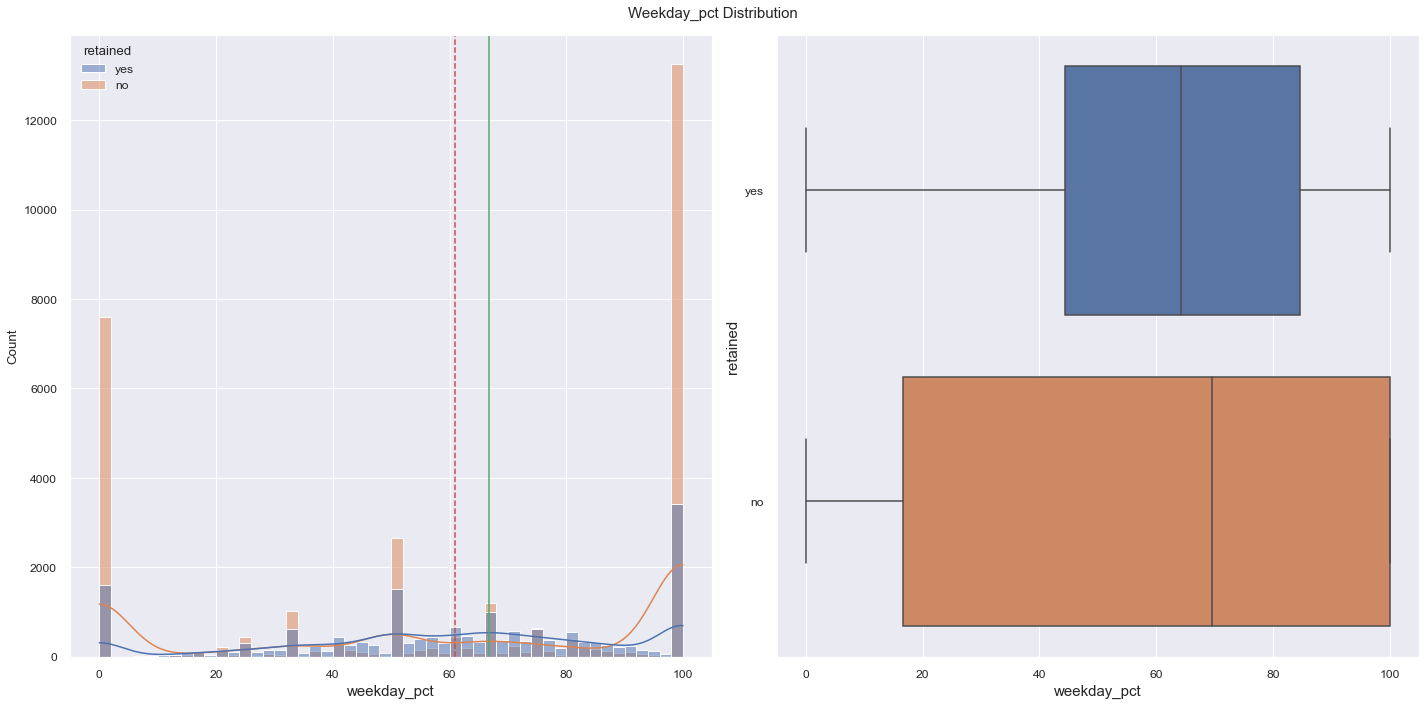

The weekday_pct description for for both respnse classes =
          weekday_pct                                                     
               count       mean        std  min   25%   50%    75%    max
retained                                                                 
no           31196.0  60.647032  40.982688  0.0  16.7  69.6  100.0  100.0
yes          18804.0  61.389034  29.487584  0.0  44.4  64.3   84.6  100.0


In [735]:
distribution_plot('weekday_pct')

### Insights:
- most of the retained users trips (from 44% to 85%) happened during workdays. On the other hand, from (18% to 100%) of the none retained users trips happened in the weekdays, more variance.

### The **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise


--------   The distribution of ultimate_black_user -----------

ultimate_black_user: 2 distinct values -  [ True False]

	 Note:The shown pecentatges % are based on the total of all users in the data, retained and not retained.



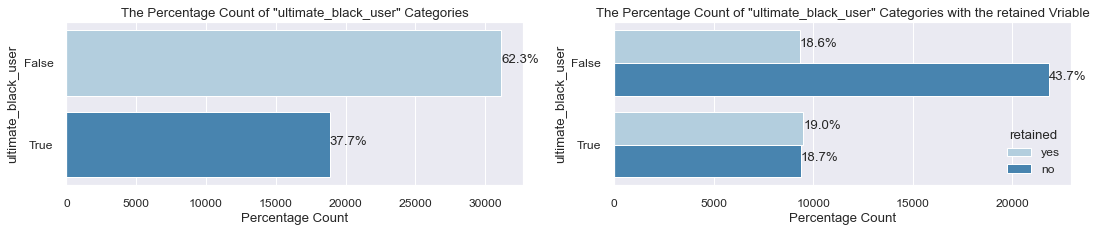

Cramér's V =  0.20491267274330732


In [738]:
distibution_bar_plot('ultimate_black_user', 'retained')

### Insights:
- Only 37.7% of the users are are black users. 
- Cramér's V =  0.2 indicates weak correlation with the target variable, "retained".

## The Predictive Power Score (PPS)

- The [PPS](https://github.com/8080labs/ppscore) is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).
- The [PPS](https://github.com/8080labs/ppscore) approach is a way to find the correlation of the predictive power between the numerical and categorical variable which is not possible via Pearson Correlation.

In [739]:
import ppscore as pps

In [740]:
def heatmap(df):
    """This function generates the heatmap for the calculated predictive power score (PPS) matrix"""
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    fig, ax = plt.subplots(figsize=(20, 18))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, annot_kws={"fontsize":13})
    ax.set_title("Predictive Power Score (PPS) matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    plt.show()

In [741]:
pps_matrix = pps.matrix(df)

In [742]:
pps_matrix['ppscore'] = round(pps_matrix['ppscore'], 2)

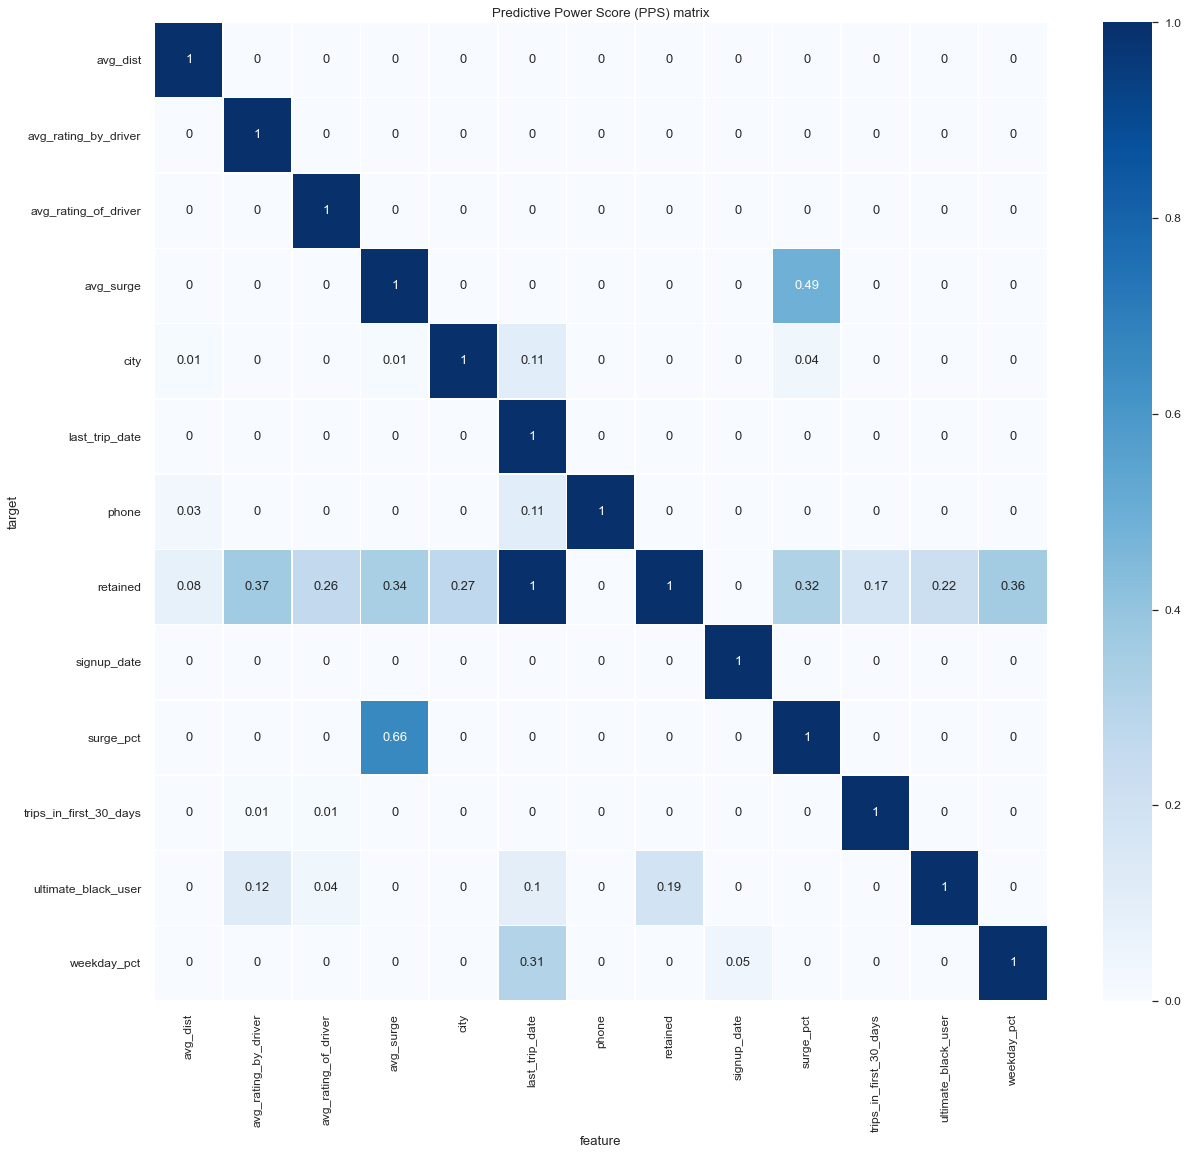

In [743]:
heatmap(pps_matrix)

In [759]:
target = pps_matrix['y'] == 'retained'
pps_matrix.loc[target, ['x', 'ppscore', 'y']].sort_values(by='ppscore', ascending=False).set_index('x').drop('retained')

,ppscore,y
x,,
last_trip_date,1.00,retained
avg_rating_by_driver,0.37,retained
weekday_pct,0.36,retained
avg_surge,0.34,retained
surge_pct,0.32,retained
city,0.27,retained
avg_rating_of_driver,0.26,retained
ultimate_black_user,0.22,retained
trips_in_first_30_days,0.17,retained


### Insights:
- The heat map shows the pairwise asymmetric predictive power, (an alternative to the correlation), between all of the variables. The table shows the features predictive power with the target variable.
- last_trip_date feature has a perfect predictive power of 1. This makes sense since the retained users are determined by the date of last trip. However, we need 30 days after the last trip date to determine whether the user is retained. We can not use this variable for modeling.
- The table shows the predictive power score for the features ordered by the strongest. avg_rating_by_driver is the second, and has PPS = 0.37 followed by weekday_pct and avg_surge.
- signup_date and phone has no predictive power. These variables, or at least, the signup date likely to be excluded in modeling.
- Note: PPS does not account for the interaction across other variables, it is only pairwise operation.

# Modeling

In [760]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

from eli5.sklearn import PermutationImportance
import eli5

 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## Data Preprocessing

We drop 'signup_date' and  'last_trip_date'. We also drop 'phone' feature since it has low predictive power and 396 missing data.

In [765]:
df_modeling = df.drop(['signup_date', 'last_trip_date', 'phone'], axis=1)

In [766]:
df_modeling.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
retained                   object
dtype: object

### Encode Categorical Features

In [767]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_modeling.retained = le.fit_transform(df_modeling['retained'])

print('The new data type fo the retained varuable is:', df_modeling.retained.dtypes)


The new data type fo the response varuable is: int64


In [774]:
df_modeling.ultimate_black_user = le.fit_transform(df_modeling['ultimate_black_user'])
print('The new data type fo the retained varuable is:', df_modeling.ultimate_black_user.dtypes)

The new data type fo the response varuable is: int64


In [769]:
cat_cols = df_modeling.select_dtypes(include=[object]).columns
cat_cols

Index(['city'], dtype='object')

In [776]:
from category_encoders import OneHotEncoder
encoder = OneHotEncoder(cols=cat_cols ,handle_unknown='return_nan',return_df=True,use_cat_names=True)
df_encoded = encoder.fit_transform(df_modeling)


/home/ahmed/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [778]:
df_encoded.head()

,city_King's Landing,city_Astapor,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,1.0,0.0,0.0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1
1,0.0,1.0,0.0,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0
2,0.0,1.0,0.0,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0
3,1.0,0.0,0.0,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1
4,0.0,0.0,1.0,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0


### Drop Missing Values

In [780]:
#df_encoded.shape

(50000, 12)

In [781]:
df_encoded.dropna(inplace = True)

In [782]:
df_encoded.shape

(41744, 12)

### Prepare the Data for Modeling: Train_Test_Split

In [779]:
# Get the name of dataframe
def get_df_name(df):
    '''Function to get the name of DataFrame'''
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [783]:
y = df_encoded.retained
X = df_encoded.drop('retained', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

data_sets =[X_train, X_test, y_train, y_test]

for d in data_sets:
    print(f'The shape of {get_df_name(d)}: {d.shape} {round(d.shape[0]/df_encoded.shape[0] *100, 0)}% \n')

The shape of X_train: (33395, 11) 80.0% 

The shape of X_test: (8349, 11) 20.0% 

The shape of y_train: (33395,) 80.0% 

The shape of y_test: (8349,) 20.0% 



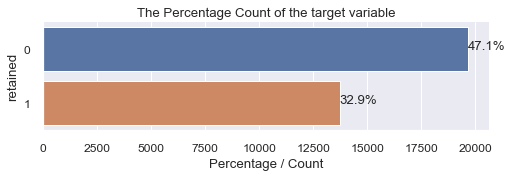

In [788]:
fig, ax = plt.subplots(figsize=(8, 2))    
# Ploting just the distribution of each variable values in the first subplot
sns.countplot(y='retained', data= y_train.to_frame(), ax=ax)
ax.set_title(f'The Percentage Count of the target variable' )
ax.set_xlabel('Percentage / Count')
ax.set_ylabel('retained')
#ax.axis("off")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('retained')
total = len(df_encoded.retained)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [789]:
# RepeatedStratifiedKFold is used for cross validation

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [803]:
clf = LogisticRegression()
clf.fit(X_std, Ys)

LogisticRegression()

In [805]:
clf.score(X_std, Ys)

0.6882186661556152

In [801]:
from sklearn.preprocessing import StandardScaler
Ys = df_encoded.retained
Xs = df_encoded.drop("retained", axis = 1)
columns = Xs.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(Xs)
X_std = pd.DataFrame(X_std, columns = columns)
X_std.head()

,city_King's Landing,city_Astapor,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,1.930817,-0.695147,-0.927988,0.342015,0.159395,0.132392,0.355856,1.262251,-0.434041,-0.348621,0.552708
1,-0.517915,1.438545,-0.927988,-0.643189,0.646351,-0.370934,-0.485268,-0.792235,-0.324845,0.542684,0.552708
2,-0.517915,1.438545,-0.927988,0.095714,-0.489881,-0.370934,-0.485268,-0.792235,1.111957,-0.911755,0.552708
3,1.930817,-0.695147,-0.927988,1.573520,-0.002924,0.333722,0.607101,1.262251,0.537236,-0.603003,0.305247
4,-0.517915,-0.695147,1.077600,2.805025,-0.327562,0.585386,0.159230,-0.792235,0.606203,-0.453481,0.305247


In [807]:
from sklearn.model_selection import train_test_split
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, Ys, test_size=0.2, random_state=42, stratify=Ys)

data_sets =[X_std_train, X_std_test, y_std_train, y_std_test]

for d in data_sets:
    print(f'The shape of {get_df_name(d)}: {d.shape} {round(d.shape[0]/df_encoded.shape[0] *100, 0)}% \n')

The shape of d: (33395, 11) 80.0% 

The shape of d: (8349, 11) 20.0% 

The shape of d: (33395,) 80.0% 

The shape of d: (8349,) 20.0% 



## Bayesian Hyperparameter Optimization using hyperopt

### Logistic Regression

In [808]:
def hyperopt_train_test(params):
    clf = LogisticRegression(**params)
    cv_score = cross_val_score(clf, X_std_train, y_std_train, cv=cv,scoring='f1').mean()
    
    return {'model': clf, 'score': cv_score}


space = { 
             'warm_start' : hp.choice('warm_start', [True, False]),
             'fit_intercept' : hp.choice('fit_intercept', [True, False]),
             'tol' : hp.uniform('tol', 0.00001, 0.0001),
             'C' : hp.uniform('C', 0.05, 3),
             'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear']),
             'max_iter' : hp.choice('max_iter', range(100,1000)),
             'multi_class' : 'auto',
             'class_weight' : 'balanced'
      }

best = 0

def f(params):
    global best
    model = hyperopt_train_test(params)['model']
    f1 = hyperopt_train_test(params)['score']
    if f1 > best:
      best = f1
      print( 'new best:', best, params)
    return {'loss': 1-f1, 'status': STATUS_OK, 'Trained_Model': model}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=20, trials=trials)
print(best)


new best:                                             
0.6244942736336762                                    
{'C': 1.733398808708467, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 253, 'multi_class': 'auto', 'solver': 'liblinear', 'tol': 6.148862495547817e-05, 'warm_start': False}
 20%|██        | 4/20 [00:10<00:45,  2.82s/trial, best loss: 0.37550572636632384]

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/home/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/home/ahmed/anaconda3/lib/py

 50%|█████     | 10/20 [00:30<00:29,  2.94s/trial, best loss: 0.37550572636632384]

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/home/ahmed/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/home/ahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/home/ahmed/anaconda3/lib/py

100%|██████████| 20/20 [01:05<00:00,  3.28s/trial, best loss: 0.37550572636632384]
{'C': 1.733398808708467, 'fit_intercept': 1, 'max_iter': 153, 'solver': 2, 'tol': 6.148862495547817e-05, 'warm_start': 1}


In [809]:
def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_Model']

In [810]:
def plot_roc_curve(X_test, y_test, model, model_name):
    
    y_pred_proba = model.predict_proba(X_test)
    rf_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    print('Area Under the Receiver Operating Characteristic Curve = ', rf_auc)
    fpr, tpr, _ =  roc_curve(y_test, y_pred_proba[:,1])

    plt.plot(fpr, tpr, marker='.', label=f'{model_name} (AUROC = %0.3f)' % rf_auc)

    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

### Decision Tree

In [811]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer

def hyperopt_train_test(params):
    dt_clf = DecisionTreeClassifier(**params)
    cv_score = cross_val_score(dt_clf, X_train, y_train, cv=cv,scoring='recall_micro').mean()
    
    return {'model': dt_clf, 'score': cv_score}

space={"splitter":hp.choice('splitter', ["best","random"]),
            "max_depth" : hp.choice('max_depth', range(1,100)),
           "min_samples_leaf":hp.choice('min_samples_leaf', range(1,5)),
           "min_weight_fraction_leaf":hp.uniform('min_weight_fraction_leaf', 0.1, 0.5),
           "max_features": hp.choice('max_features', ["auto","log2","sqrt",None]),
           "max_leaf_nodes":hp.choice('max_leaf_nodes',range(3,100)),
           'criterion': hp.choice('criterion', ["gini", "entropy"])
      }

best = 0
def f(params):
    global best
    model = hyperopt_train_test(params)['model']
    score = hyperopt_train_test(params)['score']
    if score > best:
      best = score
      print( 'new best:', best, params)
    return {'loss': 1-score, 'status': STATUS_OK, 'Trained_Model': model}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

new best:                                              
0.6616559365174427                                     
{'criterion': 'entropy', 'max_depth': 14, 'max_features': None, 'max_leaf_nodes': 55, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.3136246139115073, 'splitter': 'best'}
new best:                                                                        
0.6776762988471328                                                               
{'criterion': 'gini', 'max_depth': 72, 'max_features': 'log2', 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1354909517257049, 'splitter': 'best'}
new best:                                                                          
0.7084713280431203                                                                 
{'criterion': 'gini', 'max_depth': 53, 'max_features': None, 'max_leaf_nodes': 78, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.10305195380567361, 'splitter': 'best'}
new best:                   

In [814]:
DT_model = getBestModelfromTrials(trials)
DT_model

DecisionTreeClassifier(criterion='entropy', max_depth=53, max_leaf_nodes=23,
                       min_samples_leaf=3,
                       min_weight_fraction_leaf=0.10822476446630828)

In [815]:
DT_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=53, max_leaf_nodes=23,
                       min_samples_leaf=3,
                       min_weight_fraction_leaf=0.10822476446630828)

In [816]:
def plot_roc_curve(X_test, y_test, model, model_name):
    
    y_pred_proba = model.predict_proba(X_test)
    rf_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    print('Area Under the Receiver Operating Characteristic Curve = ', rf_auc)
    fpr, tpr, _ =  roc_curve(y_test, y_pred_proba[:,1])

    plt.plot(fpr, tpr, marker='.', label=f'{model_name} (AUROC = %0.3f)' % rf_auc)

    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

              precision    recall  f1-score   support

           0       0.79      0.69      0.74      4917
           1       0.62      0.74      0.68      3432

    accuracy                           0.71      8349
   macro avg       0.71      0.71      0.71      8349
weighted avg       0.72      0.71      0.71      8349

Area Under the Receiver Operating Characteristic Curve =  0.7660019078948304


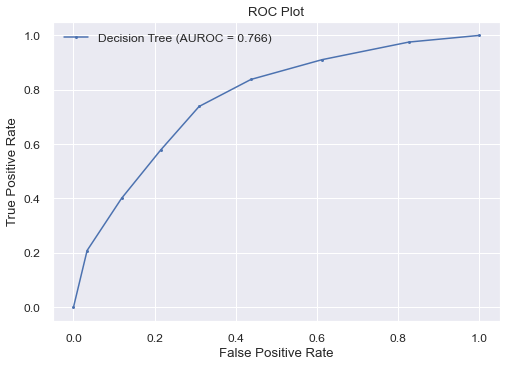

In [818]:
y_pred = DT_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_roc_curve(X_test, y_test, DT_model, 'Decision Tree')

In [812]:
# This code is taken from this source: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [820]:
cnf_matrix=confusion_matrix(y_test,y_pred.round())
cnf_matrix

array([[3395, 1522],
       [ 897, 2535]])

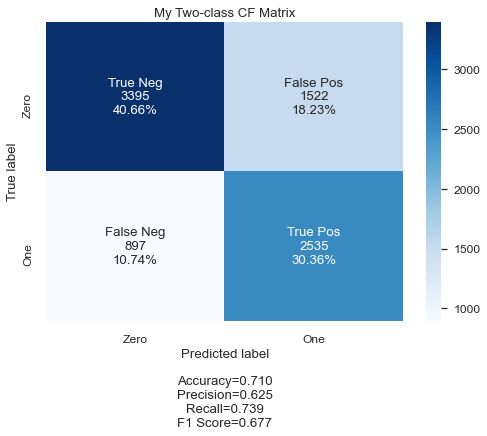

In [823]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cnf_matrix, group_names=labels, categories=categories, title='My Two-class CF Matrix')

In [829]:
X_train.columns

Index(['city_King's Landing', 'city_Astapor', 'city_Winterfell',
       'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [833]:
def hyperopt_train_test(params):
    rf_clf = RandomForestClassifier(**params)
    cv_score = cross_val_score(rf_clf, X_train, y_train, cv=cv,scoring='recall_micro').mean()
    
    return {'model': rf_clf, 'score': cv_score}

space = {
    'max_depth': hp.choice('max_depth', range(1,50)),
    'max_features': hp.choice('max_features', range(1,7)),
    'n_estimators': hp.choice('n_estimators', range(1,100)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
            }
best = 0
def f(params):
    global best
    model = hyperopt_train_test(params)['model']
    score = hyperopt_train_test(params)['score']
    if score > best:
      best = score
      print( 'new best:', best, params)
    return {'loss': 1-score, 'status': STATUS_OK, 'Trained_Model': model}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)


new best:                                              
0.7355592154514149                                     
{'criterion': 'gini', 'max_depth': 23, 'max_features': 5, 'n_estimators': 17}
new best:                                                                        
0.7387513100763587                                                               
{'criterion': 'gini', 'max_depth': 40, 'max_features': 6, 'n_estimators': 73}    
new best:                                                                           
0.7393142686030844                                                                  
{'criterion': 'gini', 'max_depth': 25, 'max_features': 2, 'n_estimators': 34}       
new best:                                                                           
0.7412666566851326                                                                  
{'criterion': 'entropy', 'max_depth': 29, 'max_features': 6, 'n_estimators': 77}    
new best:                                             

In [838]:
RF_model = getBestModelfromTrials(trials)
RF_model

RandomForestClassifier(max_depth=11, max_features=2, n_estimators=99)

In [839]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, max_features=2, n_estimators=99)

In [840]:
y_pred_proba = rf_model.predict_proba(X_test)

Area Under the Receiver Operating Characteristic Curve =  0.8356891354527107


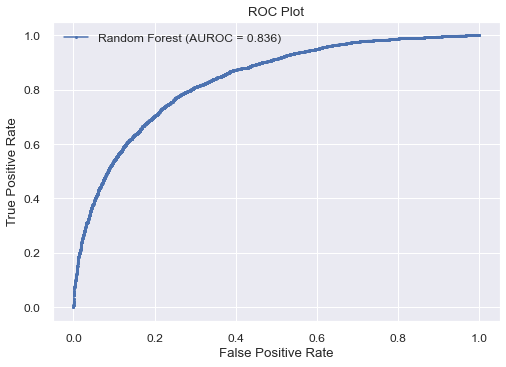

In [841]:
plot_roc_curve(X_test, y_test, RF_model, 'Random Forest')

In [842]:
y_pred = RF_model.predict(X_test)
cnf_matrix=confusion_matrix(y_test,y_pred.round())
cnf_matrix

array([[4021,  896],
       [1099, 2333]])

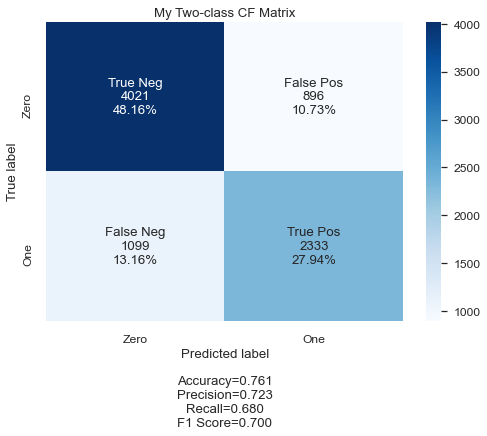

In [843]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cnf_matrix, group_names=labels, categories=categories, title='My Two-class CF Matrix')

In [846]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4917
           1       0.72      0.68      0.70      3432

    accuracy                           0.76      8349
   macro avg       0.75      0.75      0.75      8349
weighted avg       0.76      0.76      0.76      8349



### Tuning LightGBM

In [849]:
import lightgbm as lgbm


def hyperopt_train_test(params):
    

    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgbm.LGBMClassifier(
        n_estimators=20,
        learning_rate=0.01,
        class_weight= 'balanced',
        objective = 'binary',
        **params
    )

    
    cv_score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='recall_micro', n_jobs=-1).mean()
    return {'model':clf, 'score': cv_score}

space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart','goss']),

    'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    }

best = 0
def f(params):
    global best
    model = hyperopt_train_test(params)['model']
    score = hyperopt_train_test(params)['score']
    if score > best:
      best = score
      print( 'new best:', best, params)
    return {'loss': 1-score, 'status': STATUS_OK, 'Trained_Model': model}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=300, trials=trials)
print(best)

new best:                                              
0.764689324749214                                      
{'boosting_type': 'goss', 'colsample_bytree': 0.7193573638971841, 'gamma': 0.19083254665746313, 'max_depth': 7.0, 'min_child_weight': 2.8818151030092887, 'min_data_in_leaf': 59.0, 'num_leaves': 96.0}
new best:                                                                         
0.7656655187902381                                                                
{'boosting_type': 'goss', 'colsample_bytree': 0.6815436256707129, 'gamma': 0.22920051056451496, 'max_depth': 8.0, 'min_child_weight': 2.148369047063725, 'min_data_in_leaf': 86.0, 'num_leaves': 124.0}
new best:                                                                          
0.7657373858362031                                                                 
{'boosting_type': 'goss', 'colsample_bytree': 0.7290629053366519, 'gamma': 0.26694277021554413, 'max_depth': 6.0, 'min_child_weight': 1.2284955447699094e-

In [850]:
LGBM_model = getBestModelfromTrials(trials)
LGBM_model

LGBMClassifier(class_weight='balanced', colsample_bytree='0.769',
               learning_rate=0.01, n_estimators=20, num_leaves=128,
               objective='binary')

In [851]:
LGBM_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree='0.769',
               learning_rate=0.01, n_estimators=20, num_leaves=128,
               objective='binary')

In [852]:
y_pred_proba = LGBM_model.predict_proba(X_test)

Area Under the Receiver Operating Characteristic Curve =  0.8356519209554598


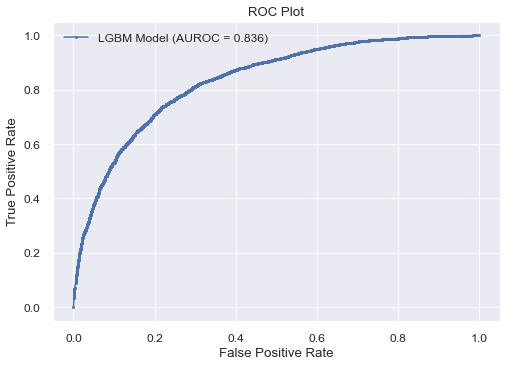

In [853]:
plot_roc_curve(X_test, y_test, LGBM_model, 'LGBM Model')

In [854]:
y_pred = LGBM_model.predict(X_test)
cnf_matrix=confusion_matrix(y_test,y_pred.round())
cnf_matrix

array([[3701, 1216],
       [ 821, 2611]])

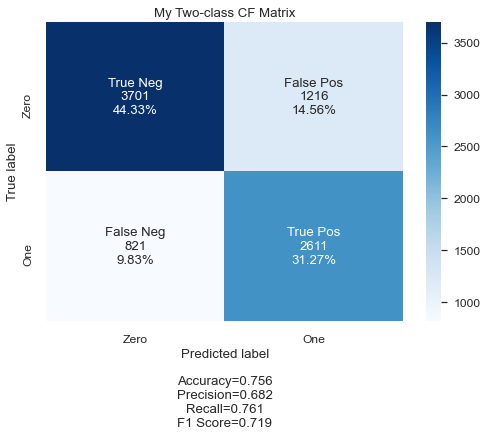

In [855]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cnf_matrix, group_names=labels, categories=categories, title='My Two-class CF Matrix')

In [856]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      4917
           1       0.68      0.76      0.72      3432

    accuracy                           0.76      8349
   macro avg       0.75      0.76      0.75      8349
weighted avg       0.76      0.76      0.76      8349



# Modeling Conclusion:

- Various machine learning algorithms are tested for modeling.
- More time is invested on the ensemble learning algorithm because of their proven powerful performance on several challenging modeling problems.
- For model tuning, Bayesian Hyperparameter Optimization is used.
- The models Hyperparameters are optimized on "recall_minor" as a loss function because we want to reduce the false negative rate. We do not need the model to miss predicting users who are likely to churn.
- Random Forest and LGBM reported similar performance with ROC AUC = 0.837. However, we choose LGBM because it did better in reducing the false negatives. Random forest reported 1099 false negative cases. On the other hand, LGBM reported 821 false negative cases, hence less chance to miss users who are likely to stop using the service. 
